
# ALAD - Toy examples¶

This is the notebook that generated Figure 2 in "Adversarially learnt anomaly detection" Credits : https://github.com/ChunyuanLI/ALICE

## Imports


In [1]:
%matplotlib inline

import os
import pdb


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import torch as torch
import torch.nn as nn

from utils.data_gmm import GMM_distribution, sample_GMM, plot_GMM
from utils.data_utils import shuffle, iter_data, ToyDataset
from tqdm import tqdm
import sklearn.datasets

In [3]:

""" parameters """

DATASET = '4gaussians' # 5gaussians, swiss_roll, s_curve
N_NOISY = 100

device = 'cuda' # "cpu" is another option

n_epoch = 600
batch_size  = 1024
dataset_size_x = 512*4
dataset_size_z = 512*4

dataset_size_x_test = 512*2
dataset_size_z_test = 512*2

input_dim = 2
latent_dim = 2
eps_dim = 2

n_layer_disc  = 2
n_hidden_disc = 256
n_layer_gen   = 3
n_hidden_gen  = 256
n_layer_inf   = 2
n_hidden_inf  = 256

In [4]:
""" Create directory for results """
result_dir = 'results/alad_toy/'
directory = result_dir
if not os.path.exists(directory):
    os.makedirs(directory)

## Training dataset

#### 4 or 5 GMM

In [5]:
""" Create dataset """

def four_five_gaussians(p1=0):
    # create X dataset
    global dataset_size_x
    means_x = map(lambda x:  np.array(x), [[2, 2],
                                          [-2, -2],
                                          [2, -2],
                                          [-2, 2],
                                           [0, 0]])
    
    means_x = list(means_x)
    std_x = 0.02
    variances_x = [np.eye(2) * std_x for _ in means_x]

    #contamination = 4.0*p/(1-p)
    priors_x = np.array([1.0, 1.0, 1.0, 1.0, p1])
    priors_x /= sum(priors_x)
    #print(priors_x)
    gaussian_mixture = GMM_distribution(means=means_x,
                                                   variances=variances_x,
                                                   priors=priors_x)
    dataset_x = sample_GMM(dataset_size_x, means_x, variances_x, priors_x, sources=('features', ))
    return dataset_x





You can control the level of the fifth gaussian in the training set with the $p$ parameter

Generate training dataset


In [6]:
dataset_x = four_five_gaussians(p1=0.0)
save_path_x = result_dir + 'X_4gmm_data_train.png'

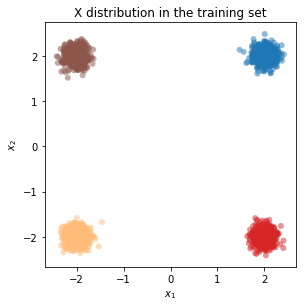

In [7]:
## input x
X_dataset  = dataset_x.data['samples']
X_targets = dataset_x.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_dataset[:, 0], X_dataset[:, 1], c=cm.tab20(X_targets.astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.set_title("X distribution in the training set" )
ax.axis('on')
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()


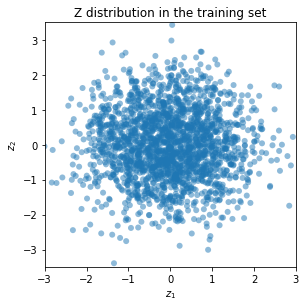

In [8]:


# create Z dataset
means_z = map(lambda x:  np.array(x), [[0, 0]])
means_z = list(means_z)
std_z = 1.0
variances_z = [np.eye(2) * std_z for _ in means_z]
priors_z = [1.0/len(means_z) for _ in means_z]

dataset_z = sample_GMM(dataset_size_z, means_z, variances_z, priors_z, sources=('features', ))
save_path_z = result_dir + 'Z_gmm_data_train.png'

##  input z
Z_dataset = dataset_z.data['samples']
Z_labels  = dataset_z.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_dataset[:, 0], Z_dataset[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.set_title("Z distribution in the training set")
ax.axis('on')
plt.savefig(save_path_z, transparent=True, bbox_inches='tight')
plt.show()



## Networks

In [9]:
""" Networks """

# Models constructors takes tensor arguments only to get input shapes for networks


class Generative_Network(nn.Module):
    def __init__(self,x, input_dim,n_layer, n_hidden, eps_dim):
        super(Generative_Network, self).__init__()
        layers = []
        self.z = z
        z_shape = list(z.shape)[1]
            
        layers.append(nn.Linear(z_shape, n_hidden))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layer-1):
            layers.append(nn.Linear(n_hidden,n_hidden))
            layers.append(nn.ReLU())
            
        layers.append(nn.Linear(n_hidden,input_dim))
        self.gn = nn.Sequential(*layers).to(device)
           
            
    def forward(self,z):
        return self.gn(z.to(device))


class Inference_Network(nn.Module):
    def __init__(self, x, latent_dim,n_layer, n_hidden, eps_dim):
        super(Inference_Network, self).__init__()
        self.x = x
        layers = []
        x_shape = list(x.shape)[1]
        layers.append(nn.Linear(input_dim, n_hidden))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layer-1):
            layers.append(nn.Linear(n_hidden,n_hidden))
            layers.append(nn.ReLU())
            
        layers.append(nn.Linear(n_hidden,latent_dim))
        self.infn = nn.Sequential(*layers).to(device)
            
    def forward(self,x):
        return self.infn(x.to(device))

    
class Data_Network_xz(nn.Module,):
    def __init__(self,x, z, n_layers=2, n_hidden=128, activation_fn=None):
        super(Data_Network_xz, self).__init__()
        layers = []
        self.h = torch.cat((x, z), 1)        
        h_shape = list(self.h.shape)[1]
    
        layers.append(nn.Linear(h_shape, n_hidden))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layers-1):
            layers.append(nn.Linear(n_hidden,n_hidden))
            layers.append(nn.ReLU())
            
        layers.append(nn.Linear(n_hidden,1))
        
        if activation_fn:
            layers.append(activation_fn)
            
        self.dn_xz = nn.Sequential(*layers).to(device)
         
        
    def forward(self,x,z):
        h = torch.cat((x.to(device),z.to(device)), 1)
        res = self.dn_xz(h)
        return res
    
    
class Data_Network_xx(nn.Module):
    def __init__(self,x, x_hat, n_layers=1, n_hidden=128, activation_fn=None):
        super(Data_Network_xx, self).__init__()
        layers = []
        self.h = torch.cat( (x, x_hat), 1)
        h_shape = list(self.h.shape)[1]
        
        layers.append(nn.Linear(h_shape, n_hidden))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layers-1):
            layers.append(nn.Linear(n_hidden,n_hidden))
            layers.append(nn.ReLU())
            
        layers.append(nn.Linear(n_hidden,1))
        if activation_fn:
            layers.append(activation_fn)
        self.dn_xx = nn.Sequential(*layers).to(device)
        
    def forward(self,x,x_hat):
        h = torch.cat( (x.to(device), x_hat.to(device)), 1)
        res = self.dn_xx(h)
        return res
    
    
class Data_Network_zz(nn.Module):
    def __init__(self,z, z_prime, n_layers=1, n_hidden=128, activation_fn=None):
        super(Data_Network_zz, self).__init__()
        layers = []
        self.h = torch.cat( (z, z_prime), 1)
        h_shape = list(self.h.shape)[1]
        
        layers.append(nn.Linear(h_shape, n_hidden))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layers-1):
            layers.append(nn.Linear(n_hidden,n_hidden))
            layers.append(nn.ReLU())
            
        layers.append(nn.Linear(n_hidden,1))
        if activation_fn:
            layers.append(activation_fn)
        self.dn_zz = nn.Sequential(*layers).to(device)
        
    def forward(self, z, z_prime):
        h = torch.cat( (z.to(device), z_prime.to(device)), 1)
        res = self.dn_zz(h)
        return res

In [10]:
x = torch.ones([batch_size, input_dim],dtype = torch.float)
z = torch.ones([batch_size, latent_dim],dtype = torch.float)   
# decoder and encoder
gen = Generative_Network(z, input_dim , n_layer_gen, n_hidden_gen, eps_dim)
inf = Inference_Network(x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim)

# Discriminates between p_x,z and x,q_z
dn_xz = Data_Network_xz(x, z, n_layers=n_layer_disc, n_hidden=n_hidden_disc)
#Discriminates between x,x and x, rec_x
dn_zz = Data_Network_zz(z,z)
#Discriminates between z,z and z, rec_z
dn_xx = Data_Network_xx(x,x)



/home/austrotaxus/anaconda3/envs/marsanomalies/lib/python3.6/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU0 GeForce GTX 660 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


### Optimizers section:

In [11]:
# Train disc op does not contain dvars_zz in the original notebook.
# That means that dn_zz network is not included in the training process
# In case of this notebook case removing dn_zz net from learning process 
# leads to insufficient regularizarion (inf(x) is not Gausian distribution)
# Trying to find explanation for such differences

disc_params = list(dn_xz.parameters())+list(dn_xx.parameters()) + list(dn_zz.parameters())
disc_optimizer = torch.optim.Adam( disc_params, lr=1e-3,betas = (0.5,0.999))

gen_params = list(gen.parameters()) + list(inf.parameters())
gen_optimizer = torch.optim.Adam(gen_params , lr = 1e-3, betas = (0.5,0.999))


### Learning procedure 

In [12]:
FG = []
FD = []

for epoch in tqdm( range(n_epoch), total=n_epoch):
    X_dataset= shuffle(X_dataset)
    Z_dataset= shuffle(Z_dataset)
    
    bce = nn.BCELoss()
    sigmoid = nn.Sigmoid()

    i = 0
    f_g= [None]*4
    f_d = None
    
    for xmb, zmb in iter_data(X_dataset, Z_dataset, size=batch_size):    
        x = torch.Tensor(xmb)
        z = torch.Tensor(zmb)
        i = i+1
        
        p_x = gen(z)
        q_z = inf(x)
        
        decoder_logit = dn_xz(p_x, z)
        encoder_logit = dn_xz(x , q_z)
    
        decoder_loss = bce(sigmoid(decoder_logit),torch.zeros_like(decoder_logit))
        encoder_loss = bce(sigmoid(encoder_logit),torch.ones_like(encoder_logit))
        
        dis_loss_xz =torch.mean(encoder_loss+decoder_loss)

        decoder_loss2 = bce(sigmoid(decoder_logit),torch.ones_like(decoder_logit))
        encoder_loss2 = bce(sigmoid(encoder_logit),torch.zeros_like(encoder_logit))

        gen_loss_xz = torch.mean((decoder_loss2))  + (torch.mean(encoder_loss2))
        
        rec_z = inf(p_x)
        rec_x = gen(q_z)
        
        x_logit_real = dn_xx(x,x)
        x_logit_fake = dn_xx(x,rec_x)
        z_logit_real = dn_zz(z,z)
        z_logit_fake = dn_zz(z,rec_z)

        x_sigmoid_real = bce(sigmoid(x_logit_real),torch.ones_like(x_logit_real))
        x_sigmoid_fake = bce(sigmoid(x_logit_fake),torch.zeros_like(x_logit_fake))

        x_sigmoid_real2 = bce(sigmoid(x_logit_real),torch.zeros_like(x_logit_real))
        x_sigmoid_fake2 = bce(sigmoid(x_logit_fake),torch.ones_like(x_logit_fake))

        z_sigmoid_real = bce(sigmoid(z_logit_real),torch.ones_like(z_logit_real))
        z_sigmoid_fake = bce(sigmoid(z_logit_fake),torch.zeros_like(z_logit_fake))

        z_sigmoid_real2 = bce(sigmoid(z_logit_real),torch.zeros_like(z_logit_real))
        z_sigmoid_fake2 = bce(sigmoid(z_logit_fake),torch.ones_like(z_logit_fake))
        
        dis_loss_x = torch.mean(x_sigmoid_real + x_sigmoid_fake)
        dis_loss_z = torch.mean(z_sigmoid_real + z_sigmoid_fake)
        disc_loss = dis_loss_xz + dis_loss_x + dis_loss_z

        cost_x = torch.mean(x_sigmoid_real2 + x_sigmoid_fake2) 
        cost_z = torch.mean(z_sigmoid_real2 + z_sigmoid_fake2)
        gen_loss = gen_loss_xz + cost_x  + cost_z
    
        for _ in range(1):
            disc_optimizer.zero_grad()
            disc_loss.backward(retain_graph = True)
            disc_optimizer.step()
            f_d = disc_loss.data
            
        # In the original article cycle below repeated 5 times, however for 
        # some reasone in my case it leads to insufficient regularization.
       
        
        for _ in range(1):
            gen_optimizer.zero_grad()
            gen_loss.backward(retain_graph = False)
            gen_optimizer.step()
            f_g = [gen_loss.data, gen_loss_xz.data, cost_x.data ,cost_z.data]
            
        FG.append(f_g)
        FD.append(f_d)
    
    print("epoch %d iter %d: discloss %f genloss %f adv_x %f recons_x %f " % (epoch, i, f_d, f_g[0], f_g[1], f_g[2]))



  0%|          | 3/600 [00:00<01:14,  8.01it/s]

epoch 0 iter 2: discloss 4.194244 genloss 4.238152 adv_x 1.477805 recons_x 1.389269 
epoch 1 iter 2: discloss 4.008469 genloss 4.472906 adv_x 1.705278 recons_x 1.390882 
epoch 2 iter 2: discloss 3.971306 genloss 4.587491 adv_x 1.842559 recons_x 1.364514 
epoch 3 iter 2: discloss 3.842155 genloss 4.905452 adv_x 2.193930 recons_x 1.320788 
epoch 4 iter 2: discloss 3.434279 genloss 5.814479 adv_x 2.966682 recons_x 1.406280 


  2%|▏         | 9/600 [00:00<00:50, 11.68it/s]

epoch 5 iter 2: discloss 3.821045 genloss 5.314071 adv_x 2.483236 recons_x 1.453855 
epoch 6 iter 2: discloss 4.046472 genloss 5.076068 adv_x 2.240231 recons_x 1.463536 
epoch 7 iter 2: discloss 3.844818 genloss 5.228795 adv_x 2.377494 recons_x 1.466426 
epoch 8 iter 2: discloss 3.734631 genloss 5.308108 adv_x 2.423263 recons_x 1.457820 
epoch 9 iter 2: discloss 3.497769 genloss 5.630360 adv_x 2.626635 recons_x 1.514771 


  2%|▎         | 15/600 [00:00<00:38, 15.08it/s]

epoch 10 iter 2: discloss 3.377559 genloss 5.834058 adv_x 2.780735 recons_x 1.573694 
epoch 11 iter 2: discloss 3.571262 genloss 5.549973 adv_x 2.481853 recons_x 1.609186 
epoch 12 iter 2: discloss 3.705276 genloss 5.232068 adv_x 2.197220 recons_x 1.586170 
epoch 13 iter 2: discloss 3.774662 genloss 5.069607 adv_x 2.144942 recons_x 1.523744 
epoch 14 iter 2: discloss 3.914994 genloss 5.083522 adv_x 2.315240 recons_x 1.435668 


  3%|▎         | 20/600 [00:01<00:33, 17.47it/s]

epoch 15 iter 2: discloss 4.055328 genloss 5.461694 adv_x 2.734720 recons_x 1.411730 
epoch 16 iter 2: discloss 3.729723 genloss 6.005676 adv_x 2.984141 recons_x 1.629790 
epoch 17 iter 2: discloss 3.358903 genloss 6.616309 adv_x 3.359567 recons_x 1.755546 
epoch 18 iter 2: discloss 3.222409 genloss 6.660993 adv_x 3.452034 recons_x 1.666637 
epoch 19 iter 2: discloss 3.510248 genloss 6.098696 adv_x 2.992473 recons_x 1.566286 


  4%|▍         | 23/600 [00:01<00:31, 18.38it/s]

epoch 20 iter 2: discloss 3.779262 genloss 5.613001 adv_x 2.547224 recons_x 1.541984 
epoch 21 iter 2: discloss 3.829993 genloss 5.331152 adv_x 2.289005 recons_x 1.532169 
epoch 22 iter 2: discloss 4.025863 genloss 5.061677 adv_x 2.043817 recons_x 1.532724 
epoch 23 iter 2: discloss 4.042955 genloss 5.117155 adv_x 2.140256 recons_x 1.521932 
epoch 24 iter 2: discloss 3.810472 genloss 5.462439 adv_x 2.433995 recons_x 1.591681 


  5%|▍         | 29/600 [00:01<00:29, 19.57it/s]

epoch 25 iter 2: discloss 3.599539 genloss 5.608695 adv_x 2.436081 recons_x 1.738847 
epoch 26 iter 2: discloss 3.410724 genloss 5.898018 adv_x 2.588175 recons_x 1.820535 
epoch 27 iter 2: discloss 3.377309 genloss 6.076458 adv_x 2.678760 recons_x 1.842718 
epoch 28 iter 2: discloss 3.546337 genloss 5.970205 adv_x 2.604343 recons_x 1.818632 
epoch 29 iter 2: discloss 3.896675 genloss 5.520526 adv_x 2.228987 recons_x 1.813457 


  6%|▌         | 35/600 [00:01<00:27, 20.44it/s]

epoch 30 iter 2: discloss 4.169981 genloss 5.156036 adv_x 1.926780 recons_x 1.778581 
epoch 31 iter 2: discloss 4.470477 genloss 4.775009 adv_x 1.640249 recons_x 1.775138 
epoch 32 iter 2: discloss 4.300979 genloss 4.757790 adv_x 1.590882 recons_x 1.841120 
epoch 33 iter 2: discloss 3.412914 genloss 5.691322 adv_x 2.133689 recons_x 2.011219 
epoch 34 iter 2: discloss 2.989443 genloss 6.419353 adv_x 2.641766 recons_x 2.013448 


  6%|▋         | 38/600 [00:01<00:27, 20.52it/s]

epoch 35 iter 2: discloss 3.067945 genloss 6.338061 adv_x 2.660897 recons_x 1.936387 
epoch 36 iter 2: discloss 3.627176 genloss 5.575128 adv_x 2.164021 recons_x 1.808536 
epoch 37 iter 2: discloss 4.292566 genloss 4.919893 adv_x 1.702366 recons_x 1.690165 
epoch 38 iter 2: discloss 4.669638 genloss 4.568313 adv_x 1.496727 recons_x 1.616695 
epoch 39 iter 2: discloss 4.179044 genloss 4.831834 adv_x 1.635607 recons_x 1.755793 


  7%|▋         | 44/600 [00:02<00:26, 20.89it/s]

epoch 40 iter 2: discloss 3.397843 genloss 5.508712 adv_x 1.956667 recons_x 1.967320 
epoch 41 iter 2: discloss 3.214617 genloss 5.647246 adv_x 2.138738 recons_x 1.861302 
epoch 42 iter 2: discloss 3.299006 genloss 5.528150 adv_x 2.059724 recons_x 1.851980 
epoch 43 iter 2: discloss 3.380322 genloss 5.390043 adv_x 1.936276 recons_x 1.857337 
epoch 44 iter 2: discloss 3.451505 genloss 5.354056 adv_x 1.924117 recons_x 1.850797 


  8%|▊         | 50/600 [00:02<00:25, 21.17it/s]

epoch 45 iter 2: discloss 3.487387 genloss 5.457046 adv_x 2.005919 recons_x 1.865284 
epoch 46 iter 2: discloss 3.532809 genloss 5.499762 adv_x 2.060952 recons_x 1.849480 
epoch 47 iter 2: discloss 3.471337 genloss 5.593794 adv_x 2.116417 recons_x 1.864328 
epoch 48 iter 2: discloss 3.355379 genloss 5.715060 adv_x 2.206196 recons_x 1.934035 
epoch 49 iter 2: discloss 3.437589 genloss 5.544766 adv_x 1.991938 recons_x 1.999095 


  9%|▉         | 53/600 [00:02<00:26, 20.95it/s]

epoch 50 iter 2: discloss 3.379928 genloss 5.612185 adv_x 1.943552 recons_x 2.095783 
epoch 51 iter 2: discloss 3.303452 genloss 5.771235 adv_x 2.044706 recons_x 2.127041 
epoch 52 iter 2: discloss 3.239743 genloss 5.979225 adv_x 2.192226 recons_x 2.169865 
epoch 53 iter 2: discloss 3.225059 genloss 6.185204 adv_x 2.352491 recons_x 2.197636 
epoch 54 iter 2: discloss 3.174922 genloss 6.340248 adv_x 2.470955 recons_x 2.230250 


 10%|▉         | 59/600 [00:02<00:25, 21.11it/s]

epoch 55 iter 2: discloss 3.153974 genloss 6.382478 adv_x 2.529875 recons_x 2.236362 
epoch 56 iter 2: discloss 3.305391 genloss 6.104526 adv_x 2.341542 recons_x 2.149757 
epoch 57 iter 2: discloss 3.410435 genloss 5.988174 adv_x 2.229213 recons_x 2.133851 
epoch 58 iter 2: discloss 3.632866 genloss 5.649708 adv_x 1.887814 recons_x 2.096038 
epoch 59 iter 2: discloss 3.663046 genloss 5.438100 adv_x 1.613030 recons_x 2.106815 


 10%|█         | 62/600 [00:03<00:25, 21.27it/s]

epoch 60 iter 2: discloss 3.455721 genloss 5.539254 adv_x 1.674459 recons_x 2.155465 
epoch 61 iter 2: discloss 3.254105 genloss 5.759641 adv_x 1.896331 recons_x 2.174061 
epoch 62 iter 2: discloss 3.102268 genloss 6.104664 adv_x 2.255098 recons_x 2.170146 
epoch 63 iter 2: discloss 3.050780 genloss 6.347884 adv_x 2.552111 recons_x 2.116579 


 11%|█▏        | 68/600 [00:03<00:25, 20.87it/s]

epoch 64 iter 2: discloss 3.143376 genloss 6.357125 adv_x 2.552265 recons_x 2.085559 
epoch 65 iter 2: discloss 3.404457 genloss 6.072240 adv_x 2.257304 recons_x 2.050130 
epoch 66 iter 2: discloss 3.488256 genloss 5.978592 adv_x 2.049475 recons_x 2.124461 
epoch 67 iter 2: discloss 3.371105 genloss 6.097280 adv_x 2.029899 recons_x 2.250827 
epoch 68 iter 2: discloss 3.302850 genloss 6.104595 adv_x 1.950214 recons_x 2.379314 


 12%|█▏        | 74/600 [00:03<00:24, 21.07it/s]

epoch 69 iter 2: discloss 3.381562 genloss 6.079844 adv_x 1.932832 recons_x 2.483215 
epoch 70 iter 2: discloss 3.419672 genloss 6.251690 adv_x 2.070133 recons_x 2.554084 
epoch 71 iter 2: discloss 3.246097 genloss 6.637709 adv_x 2.436845 recons_x 2.534668 
epoch 72 iter 2: discloss 3.065666 genloss 7.004875 adv_x 2.804488 recons_x 2.463664 
epoch 73 iter 2: discloss 3.016438 genloss 7.087115 adv_x 2.965365 recons_x 2.365857 


 13%|█▎        | 77/600 [00:03<00:24, 20.93it/s]

epoch 74 iter 2: discloss 3.211938 genloss 6.672045 adv_x 2.655532 recons_x 2.231818 
epoch 75 iter 2: discloss 3.571886 genloss 6.285553 adv_x 2.225803 recons_x 2.205696 
epoch 76 iter 2: discloss 3.781520 genloss 6.071722 adv_x 1.892751 recons_x 2.267436 
epoch 77 iter 2: discloss 3.431152 genloss 6.023982 adv_x 1.830837 recons_x 2.276846 
epoch 78 iter 2: discloss 3.070821 genloss 6.155075 adv_x 2.013707 recons_x 2.308120 


 14%|█▍        | 83/600 [00:04<00:25, 20.61it/s]

epoch 79 iter 2: discloss 2.956288 genloss 6.296978 adv_x 2.224735 recons_x 2.286695 
epoch 80 iter 2: discloss 2.963201 genloss 6.339606 adv_x 2.427932 recons_x 2.205170 
epoch 81 iter 2: discloss 3.211329 genloss 6.102619 adv_x 2.478152 recons_x 1.981003 
epoch 82 iter 2: discloss 3.339385 genloss 6.029224 adv_x 2.474926 recons_x 1.900121 
epoch 83 iter 2: discloss 3.321830 genloss 6.009053 adv_x 2.420439 recons_x 1.877845 


 15%|█▍        | 89/600 [00:04<00:24, 21.06it/s]

epoch 84 iter 2: discloss 3.236884 genloss 5.960908 adv_x 2.328900 recons_x 1.876331 
epoch 85 iter 2: discloss 3.244865 genloss 5.821162 adv_x 2.153480 recons_x 1.876883 
epoch 86 iter 2: discloss 3.387945 genloss 5.592791 adv_x 1.904335 recons_x 1.911875 
epoch 87 iter 2: discloss 3.564420 genloss 5.543168 adv_x 1.748122 recons_x 2.044208 
epoch 88 iter 2: discloss 3.439477 genloss 5.989921 adv_x 2.062196 recons_x 2.180432 


 15%|█▌        | 92/600 [00:04<00:23, 21.29it/s]

epoch 89 iter 2: discloss 3.243732 genloss 6.313473 adv_x 2.412145 recons_x 2.196666 
epoch 90 iter 2: discloss 3.124879 genloss 6.294929 adv_x 2.457390 recons_x 2.195240 
epoch 91 iter 2: discloss 3.117847 genloss 6.337070 adv_x 2.628662 recons_x 2.107470 
epoch 92 iter 2: discloss 3.205963 genloss 6.257309 adv_x 2.706977 recons_x 2.011425 
epoch 93 iter 2: discloss 3.300297 genloss 6.074484 adv_x 2.633349 recons_x 1.912561 


 16%|█▋        | 98/600 [00:04<00:24, 20.89it/s]

epoch 94 iter 2: discloss 3.314575 genloss 5.923538 adv_x 2.558057 recons_x 1.860038 
epoch 95 iter 2: discloss 3.533322 genloss 5.557868 adv_x 2.441535 recons_x 1.641726 
epoch 96 iter 2: discloss 3.927226 genloss 5.174210 adv_x 2.190102 recons_x 1.468992 
epoch 97 iter 2: discloss 3.975049 genloss 5.001787 adv_x 1.934133 recons_x 1.495390 
epoch 98 iter 2: discloss 3.803079 genloss 5.019639 adv_x 2.034999 recons_x 1.459118 


 17%|█▋        | 104/600 [00:05<00:23, 20.87it/s]

epoch 99 iter 2: discloss 3.805694 genloss 4.981379 adv_x 2.077988 recons_x 1.425932 
epoch 100 iter 2: discloss 3.959149 genloss 4.804521 adv_x 1.923791 recons_x 1.423006 
epoch 101 iter 2: discloss 4.116989 genloss 4.550620 adv_x 1.675007 recons_x 1.432350 
epoch 102 iter 2: discloss 4.234970 genloss 4.385091 adv_x 1.508971 recons_x 1.445039 
epoch 103 iter 2: discloss 4.242096 genloss 4.333910 adv_x 1.451540 recons_x 1.456113 


 18%|█▊        | 107/600 [00:05<00:23, 20.97it/s]

epoch 104 iter 2: discloss 4.159064 genloss 4.372773 adv_x 1.485002 recons_x 1.461130 
epoch 105 iter 2: discloss 4.022766 genloss 4.530670 adv_x 1.613731 recons_x 1.491341 
epoch 106 iter 2: discloss 3.887930 genloss 4.698491 adv_x 1.604630 recons_x 1.624634 
epoch 107 iter 2: discloss 3.922059 genloss 4.652480 adv_x 1.752244 recons_x 1.466480 
epoch 108 iter 2: discloss 3.963618 genloss 4.614828 adv_x 1.744475 recons_x 1.447234 


 19%|█▉        | 113/600 [00:05<00:22, 21.18it/s]

epoch 109 iter 2: discloss 3.994786 genloss 4.630273 adv_x 1.803617 recons_x 1.401757 
epoch 110 iter 2: discloss 4.004940 genloss 4.586058 adv_x 1.735385 recons_x 1.433747 
epoch 111 iter 2: discloss 3.971040 genloss 4.601602 adv_x 1.746040 recons_x 1.439079 
epoch 112 iter 2: discloss 3.952392 genloss 4.610856 adv_x 1.753880 recons_x 1.446957 
epoch 113 iter 2: discloss 3.946768 genloss 4.598211 adv_x 1.770501 recons_x 1.409986 


 20%|█▉        | 119/600 [00:05<00:22, 21.21it/s]

epoch 114 iter 2: discloss 3.935161 genloss 4.606071 adv_x 1.776288 recons_x 1.417162 
epoch 115 iter 2: discloss 3.902329 genloss 4.646894 adv_x 1.789811 recons_x 1.440609 
epoch 116 iter 2: discloss 3.901179 genloss 4.618183 adv_x 1.799768 recons_x 1.399513 
epoch 117 iter 2: discloss 3.895024 genloss 4.613250 adv_x 1.797523 recons_x 1.400375 
epoch 118 iter 2: discloss 3.900222 genloss 4.608754 adv_x 1.784555 recons_x 1.408586 


 20%|██        | 122/600 [00:05<00:22, 20.93it/s]

epoch 119 iter 2: discloss 3.895011 genloss 4.590096 adv_x 1.777740 recons_x 1.394059 
epoch 120 iter 2: discloss 3.901443 genloss 4.562789 adv_x 1.747393 recons_x 1.396066 
epoch 121 iter 2: discloss 3.896469 genloss 4.568361 adv_x 1.739169 recons_x 1.404046 
epoch 122 iter 2: discloss 3.903593 genloss 4.531768 adv_x 1.711415 recons_x 1.394141 
epoch 123 iter 2: discloss 3.901201 genloss 4.531336 adv_x 1.700842 recons_x 1.398512 


 21%|██▏       | 128/600 [00:06<00:22, 20.72it/s]

epoch 124 iter 2: discloss 3.914164 genloss 4.523257 adv_x 1.688595 recons_x 1.401299 
epoch 125 iter 2: discloss 3.889902 genloss 4.538118 adv_x 1.692842 recons_x 1.409444 
epoch 126 iter 2: discloss 3.894992 genloss 4.543358 adv_x 1.697375 recons_x 1.403950 
epoch 127 iter 2: discloss 3.893854 genloss 4.546128 adv_x 1.702385 recons_x 1.398432 
epoch 128 iter 2: discloss 3.871837 genloss 4.571959 adv_x 1.725239 recons_x 1.401721 


 22%|██▏       | 134/600 [00:06<00:22, 20.75it/s]

epoch 129 iter 2: discloss 3.869116 genloss 4.572181 adv_x 1.721304 recons_x 1.402717 
epoch 130 iter 2: discloss 3.876457 genloss 4.584903 adv_x 1.737405 recons_x 1.402684 
epoch 131 iter 2: discloss 3.873707 genloss 4.583449 adv_x 1.730298 recons_x 1.407562 
epoch 132 iter 2: discloss 3.876957 genloss 4.562647 adv_x 1.715862 recons_x 1.406726 
epoch 133 iter 2: discloss 3.884763 genloss 4.552298 adv_x 1.705387 recons_x 1.409106 


 23%|██▎       | 137/600 [00:06<00:22, 20.89it/s]

epoch 134 iter 2: discloss 3.891822 genloss 4.546459 adv_x 1.699594 recons_x 1.409039 
epoch 135 iter 2: discloss 3.883562 genloss 4.546332 adv_x 1.697935 recons_x 1.409469 
epoch 136 iter 2: discloss 3.888064 genloss 4.539138 adv_x 1.692743 recons_x 1.408535 
epoch 137 iter 2: discloss 3.883927 genloss 4.539294 adv_x 1.680996 recons_x 1.409839 
epoch 138 iter 2: discloss 3.863123 genloss 4.576121 adv_x 1.720226 recons_x 1.408362 


 24%|██▍       | 143/600 [00:06<00:22, 20.72it/s]

epoch 139 iter 2: discloss 3.865818 genloss 4.573038 adv_x 1.713935 recons_x 1.404934 
epoch 140 iter 2: discloss 3.868479 genloss 4.566691 adv_x 1.703111 recons_x 1.409342 
epoch 141 iter 2: discloss 3.870270 genloss 4.563267 adv_x 1.691904 recons_x 1.407810 
epoch 142 iter 2: discloss 3.868686 genloss 4.581713 adv_x 1.705374 recons_x 1.405808 
epoch 143 iter 2: discloss 3.854629 genloss 4.602645 adv_x 1.720770 recons_x 1.408387 


 25%|██▍       | 149/600 [00:07<00:21, 20.67it/s]

epoch 144 iter 2: discloss 3.808737 genloss 4.651768 adv_x 1.744000 recons_x 1.425812 
epoch 145 iter 2: discloss 3.852499 genloss 4.599298 adv_x 1.706375 recons_x 1.417526 
epoch 146 iter 2: discloss 3.850949 genloss 4.583375 adv_x 1.689963 recons_x 1.429725 
epoch 147 iter 2: discloss 3.838129 genloss 4.603378 adv_x 1.705260 recons_x 1.430857 
epoch 148 iter 2: discloss 3.850675 genloss 4.579795 adv_x 1.706800 recons_x 1.405587 


 25%|██▌       | 152/600 [00:07<00:21, 20.75it/s]

epoch 149 iter 2: discloss 3.855056 genloss 4.581575 adv_x 1.702219 recons_x 1.420816 
epoch 150 iter 2: discloss 3.902770 genloss 4.535504 adv_x 1.638940 recons_x 1.422446 
epoch 151 iter 2: discloss 3.923524 genloss 4.538948 adv_x 1.615062 recons_x 1.434891 
epoch 152 iter 2: discloss 3.916018 genloss 4.558355 adv_x 1.630630 recons_x 1.415935 
epoch 153 iter 2: discloss 3.876494 genloss 4.604964 adv_x 1.672052 recons_x 1.410090 


 26%|██▋       | 158/600 [00:07<00:21, 20.85it/s]

epoch 154 iter 2: discloss 3.756969 genloss 4.738462 adv_x 1.735190 recons_x 1.467870 
epoch 155 iter 2: discloss 3.752482 genloss 4.773265 adv_x 1.807020 recons_x 1.473511 
epoch 156 iter 2: discloss 3.801270 genloss 4.694933 adv_x 1.808331 recons_x 1.410088 
epoch 157 iter 2: discloss 3.884514 genloss 4.592421 adv_x 1.700408 recons_x 1.415038 
epoch 158 iter 2: discloss 3.844612 genloss 4.644330 adv_x 1.617293 recons_x 1.528213 


 27%|██▋       | 164/600 [00:07<00:20, 21.06it/s]

epoch 159 iter 2: discloss 3.859743 genloss 4.658970 adv_x 1.583718 recons_x 1.552541 
epoch 160 iter 2: discloss 3.776714 genloss 4.685982 adv_x 1.688914 recons_x 1.498012 
epoch 161 iter 2: discloss 3.800555 genloss 4.724815 adv_x 1.774516 recons_x 1.424258 
epoch 162 iter 2: discloss 3.778468 genloss 4.716591 adv_x 1.768641 recons_x 1.426127 
epoch 163 iter 2: discloss 3.792233 genloss 4.685763 adv_x 1.748819 recons_x 1.419244 


 28%|██▊       | 167/600 [00:08<00:20, 21.07it/s]

epoch 164 iter 2: discloss 3.837247 genloss 4.632587 adv_x 1.725771 recons_x 1.411402 
epoch 165 iter 2: discloss 3.851930 genloss 4.621064 adv_x 1.727275 recons_x 1.410215 
epoch 166 iter 2: discloss 3.774274 genloss 4.728090 adv_x 1.802348 recons_x 1.439086 
epoch 167 iter 2: discloss 3.847512 genloss 4.630609 adv_x 1.728917 recons_x 1.405948 
epoch 168 iter 2: discloss 3.881835 genloss 4.601774 adv_x 1.687572 recons_x 1.407221 


 29%|██▉       | 173/600 [00:08<00:20, 20.88it/s]

epoch 169 iter 2: discloss 3.866799 genloss 4.637362 adv_x 1.681779 recons_x 1.433268 
epoch 170 iter 2: discloss 3.881006 genloss 4.633706 adv_x 1.667454 recons_x 1.429644 
epoch 171 iter 2: discloss 3.844520 genloss 4.722034 adv_x 1.758157 recons_x 1.418905 
epoch 172 iter 2: discloss 3.767357 genloss 4.787636 adv_x 1.835719 recons_x 1.415892 
epoch 173 iter 2: discloss 3.722807 genloss 4.874141 adv_x 1.936504 recons_x 1.404227 


 30%|██▉       | 179/600 [00:08<00:20, 20.76it/s]

epoch 174 iter 2: discloss 3.714426 genloss 4.859923 adv_x 1.941596 recons_x 1.407295 
epoch 175 iter 2: discloss 3.780727 genloss 4.765069 adv_x 1.848302 recons_x 1.412746 
epoch 176 iter 2: discloss 3.855773 genloss 4.649540 adv_x 1.731736 recons_x 1.407054 
epoch 177 iter 2: discloss 3.837101 genloss 4.655114 adv_x 1.699809 recons_x 1.415910 
epoch 178 iter 2: discloss 3.729575 genloss 4.810640 adv_x 1.833675 recons_x 1.433950 


 30%|███       | 182/600 [00:08<00:20, 20.39it/s]

epoch 179 iter 2: discloss 3.807623 genloss 4.706294 adv_x 1.740097 recons_x 1.431616 
epoch 180 iter 2: discloss 3.888969 genloss 4.611703 adv_x 1.677366 recons_x 1.428282 
epoch 181 iter 2: discloss 3.859853 genloss 4.635138 adv_x 1.677539 recons_x 1.443618 
epoch 182 iter 2: discloss 3.785159 genloss 4.766504 adv_x 1.835260 recons_x 1.417906 
epoch 183 iter 2: discloss 3.733038 genloss 4.814564 adv_x 1.852727 recons_x 1.433116 


 31%|███▏      | 188/600 [00:09<00:19, 21.07it/s]

epoch 184 iter 2: discloss 3.772360 genloss 4.764241 adv_x 1.795110 recons_x 1.423080 
epoch 185 iter 2: discloss 3.886482 genloss 4.657743 adv_x 1.675435 recons_x 1.417207 
epoch 186 iter 2: discloss 3.782488 genloss 4.809097 adv_x 1.738215 recons_x 1.457637 
epoch 187 iter 2: discloss 3.730680 genloss 4.835418 adv_x 1.803254 recons_x 1.428299 
epoch 188 iter 2: discloss 3.750815 genloss 4.801100 adv_x 1.807708 recons_x 1.416670 


 32%|███▏      | 194/600 [00:09<00:19, 21.20it/s]

epoch 189 iter 2: discloss 3.846747 genloss 4.690595 adv_x 1.687863 recons_x 1.454438 
epoch 190 iter 2: discloss 3.908434 genloss 4.641908 adv_x 1.666442 recons_x 1.449471 
epoch 191 iter 2: discloss 3.885617 genloss 4.665165 adv_x 1.619827 recons_x 1.509013 
epoch 192 iter 2: discloss 3.796096 genloss 4.778204 adv_x 1.744985 recons_x 1.478043 
epoch 193 iter 2: discloss 3.783178 genloss 4.750099 adv_x 1.799323 recons_x 1.417310 


 33%|███▎      | 197/600 [00:09<00:19, 21.09it/s]

epoch 194 iter 2: discloss 3.786822 genloss 4.735615 adv_x 1.804855 recons_x 1.418347 
epoch 195 iter 2: discloss 3.881435 genloss 4.613283 adv_x 1.677584 recons_x 1.403020 
epoch 196 iter 2: discloss 3.893902 genloss 4.603679 adv_x 1.652370 recons_x 1.406065 
epoch 197 iter 2: discloss 3.821707 genloss 4.675764 adv_x 1.708624 recons_x 1.411362 
epoch 198 iter 2: discloss 3.818747 genloss 4.670486 adv_x 1.658260 recons_x 1.422134 


 34%|███▍      | 203/600 [00:09<00:19, 20.89it/s]

epoch 199 iter 2: discloss 3.784408 genloss 4.768756 adv_x 1.674346 recons_x 1.466835 
epoch 200 iter 2: discloss 3.801152 genloss 4.777648 adv_x 1.751660 recons_x 1.430354 
epoch 201 iter 2: discloss 3.765306 genloss 4.772096 adv_x 1.776610 recons_x 1.424791 
epoch 202 iter 2: discloss 3.758361 genloss 4.793543 adv_x 1.790106 recons_x 1.429292 
epoch 203 iter 2: discloss 3.741783 genloss 4.810614 adv_x 1.789920 recons_x 1.419384 


 35%|███▍      | 209/600 [00:10<00:18, 20.78it/s]

epoch 204 iter 2: discloss 3.693673 genloss 4.876860 adv_x 1.853323 recons_x 1.428489 
epoch 205 iter 2: discloss 3.704099 genloss 4.882950 adv_x 1.858958 recons_x 1.419903 
epoch 206 iter 2: discloss 3.782625 genloss 4.816221 adv_x 1.853502 recons_x 1.406583 
epoch 207 iter 2: discloss 3.805089 genloss 4.781507 adv_x 1.781312 recons_x 1.447941 
epoch 208 iter 2: discloss 3.967148 genloss 4.604438 adv_x 1.614864 recons_x 1.422347 


 35%|███▌      | 212/600 [00:10<00:18, 20.74it/s]

epoch 209 iter 2: discloss 3.947735 genloss 4.651256 adv_x 1.645853 recons_x 1.454499 
epoch 210 iter 2: discloss 3.818211 genloss 4.807580 adv_x 1.658539 recons_x 1.514695 
epoch 211 iter 2: discloss 3.671030 genloss 4.911326 adv_x 1.795616 recons_x 1.479225 
epoch 212 iter 2: discloss 3.693912 genloss 4.892304 adv_x 1.854270 recons_x 1.416079 
epoch 213 iter 2: discloss 3.730489 genloss 4.787525 adv_x 1.778182 recons_x 1.432519 


 36%|███▋      | 218/600 [00:10<00:18, 20.93it/s]

epoch 214 iter 2: discloss 3.812048 genloss 4.682883 adv_x 1.681515 recons_x 1.420151 
epoch 215 iter 2: discloss 3.803158 genloss 4.703312 adv_x 1.730157 recons_x 1.410213 
epoch 216 iter 2: discloss 3.779834 genloss 4.712614 adv_x 1.756433 recons_x 1.403177 
epoch 217 iter 2: discloss 3.784735 genloss 4.701908 adv_x 1.740370 recons_x 1.406504 
epoch 218 iter 2: discloss 3.787553 genloss 4.708492 adv_x 1.751860 recons_x 1.407362 


 37%|███▋      | 224/600 [00:10<00:17, 21.21it/s]

epoch 219 iter 2: discloss 3.795863 genloss 4.722454 adv_x 1.748333 recons_x 1.407930 
epoch 220 iter 2: discloss 3.805152 genloss 4.742317 adv_x 1.761500 recons_x 1.408331 
epoch 221 iter 2: discloss 3.779160 genloss 4.793397 adv_x 1.774595 recons_x 1.409186 
epoch 222 iter 2: discloss 3.786433 genloss 4.794440 adv_x 1.756680 recons_x 1.409524 
epoch 223 iter 2: discloss 3.678868 genloss 4.937833 adv_x 1.812403 recons_x 1.436358 


 38%|███▊      | 227/600 [00:10<00:17, 21.09it/s]

epoch 224 iter 2: discloss 3.562801 genloss 5.094924 adv_x 1.977433 recons_x 1.431800 
epoch 225 iter 2: discloss 3.565206 genloss 5.092495 adv_x 2.064735 recons_x 1.407686 
epoch 226 iter 2: discloss 3.649729 genloss 4.984385 adv_x 1.997374 recons_x 1.413061 
epoch 227 iter 2: discloss 3.846640 genloss 4.748979 adv_x 1.771019 recons_x 1.408810 
epoch 228 iter 2: discloss 3.867243 genloss 4.722677 adv_x 1.729054 recons_x 1.421016 


 39%|███▉      | 233/600 [00:11<00:17, 20.64it/s]

epoch 229 iter 2: discloss 3.835110 genloss 4.751373 adv_x 1.780740 recons_x 1.413086 
epoch 230 iter 2: discloss 3.858037 genloss 4.713590 adv_x 1.736131 recons_x 1.411838 
epoch 231 iter 2: discloss 3.927131 genloss 4.640159 adv_x 1.599743 recons_x 1.432135 
epoch 232 iter 2: discloss 3.856367 genloss 4.726465 adv_x 1.620182 recons_x 1.442178 
epoch 233 iter 2: discloss 3.740216 genloss 4.855962 adv_x 1.707271 recons_x 1.445502 


 40%|███▉      | 239/600 [00:11<00:17, 20.87it/s]

epoch 234 iter 2: discloss 3.644011 genloss 4.930830 adv_x 1.841172 recons_x 1.419357 
epoch 235 iter 2: discloss 3.578061 genloss 5.026546 adv_x 1.894672 recons_x 1.446637 
epoch 236 iter 2: discloss 3.739923 genloss 4.834478 adv_x 1.790715 recons_x 1.417136 
epoch 237 iter 2: discloss 3.816724 genloss 4.757219 adv_x 1.729195 recons_x 1.409434 
epoch 238 iter 2: discloss 3.806666 genloss 4.785982 adv_x 1.744569 recons_x 1.410455 


 40%|████      | 242/600 [00:11<00:17, 20.63it/s]

epoch 239 iter 2: discloss 3.747081 genloss 4.873521 adv_x 1.821556 recons_x 1.432736 
epoch 240 iter 2: discloss 3.736089 genloss 4.898700 adv_x 1.823025 recons_x 1.452936 
epoch 241 iter 2: discloss 3.887671 genloss 4.693072 adv_x 1.665703 recons_x 1.426871 
epoch 242 iter 2: discloss 3.934276 genloss 4.611728 adv_x 1.594140 recons_x 1.414645 


 41%|████▏     | 248/600 [00:11<00:17, 20.51it/s]

epoch 243 iter 2: discloss 3.879609 genloss 4.665953 adv_x 1.615286 recons_x 1.410357 
epoch 244 iter 2: discloss 3.678221 genloss 4.915505 adv_x 1.742289 recons_x 1.485791 
epoch 245 iter 2: discloss 3.627802 genloss 4.981757 adv_x 1.898796 recons_x 1.428483 
epoch 246 iter 2: discloss 3.652504 genloss 4.943086 adv_x 1.940137 recons_x 1.407971 
epoch 247 iter 2: discloss 3.723995 genloss 4.869004 adv_x 1.872834 recons_x 1.404408 


 42%|████▏     | 251/600 [00:12<00:17, 20.35it/s]

epoch 248 iter 2: discloss 3.818634 genloss 4.746740 adv_x 1.768024 recons_x 1.401676 
epoch 249 iter 2: discloss 3.796293 genloss 4.766578 adv_x 1.781398 recons_x 1.408305 
epoch 250 iter 2: discloss 3.669967 genloss 4.926957 adv_x 1.822845 recons_x 1.502405 
epoch 251 iter 2: discloss 3.698574 genloss 4.878241 adv_x 1.778991 recons_x 1.420898 


 43%|████▎     | 257/600 [00:12<00:16, 20.48it/s]

epoch 252 iter 2: discloss 3.719949 genloss 4.868445 adv_x 1.774415 recons_x 1.413623 
epoch 253 iter 2: discloss 3.680080 genloss 4.900841 adv_x 1.780571 recons_x 1.408023 
epoch 254 iter 2: discloss 3.691855 genloss 4.912863 adv_x 1.799152 recons_x 1.421309 
epoch 255 iter 2: discloss 3.758679 genloss 4.813619 adv_x 1.710224 recons_x 1.436541 
epoch 256 iter 2: discloss 3.680439 genloss 4.926229 adv_x 1.815814 recons_x 1.436876 


 43%|████▎     | 260/600 [00:12<00:16, 20.78it/s]

epoch 257 iter 2: discloss 3.652818 genloss 5.016448 adv_x 1.902775 recons_x 1.448775 
epoch 258 iter 2: discloss 3.606381 genloss 5.099109 adv_x 2.040684 recons_x 1.415501 
epoch 259 iter 2: discloss 3.655106 genloss 5.068954 adv_x 2.018452 recons_x 1.427037 
epoch 260 iter 2: discloss 3.792424 genloss 4.859062 adv_x 1.786405 recons_x 1.413349 
epoch 261 iter 2: discloss 3.915208 genloss 4.745794 adv_x 1.686042 recons_x 1.415073 


 44%|████▍     | 266/600 [00:12<00:16, 20.59it/s]

epoch 262 iter 2: discloss 3.789816 genloss 4.817107 adv_x 1.702985 recons_x 1.418189 
epoch 263 iter 2: discloss 3.643793 genloss 5.011339 adv_x 1.903841 recons_x 1.419417 
epoch 264 iter 2: discloss 3.558348 genloss 5.100202 adv_x 1.965857 recons_x 1.426110 
epoch 265 iter 2: discloss 3.620031 genloss 5.032642 adv_x 1.906509 recons_x 1.424597 
epoch 266 iter 2: discloss 3.698976 genloss 4.976736 adv_x 1.808181 recons_x 1.445198 


 45%|████▌     | 272/600 [00:13<00:16, 20.46it/s]

epoch 267 iter 2: discloss 3.448250 genloss 5.425231 adv_x 2.057855 recons_x 1.527243 
epoch 268 iter 2: discloss 3.615598 genloss 5.191574 adv_x 2.008654 recons_x 1.464978 
epoch 269 iter 2: discloss 3.686265 genloss 5.118037 adv_x 2.026612 recons_x 1.434144 
epoch 270 iter 2: discloss 3.840411 genloss 4.875504 adv_x 1.785740 recons_x 1.444720 
epoch 271 iter 2: discloss 4.002292 genloss 4.668061 adv_x 1.579747 recons_x 1.463022 


 46%|████▌     | 275/600 [00:13<00:15, 20.36it/s]

epoch 272 iter 2: discloss 3.860384 genloss 4.769300 adv_x 1.702759 recons_x 1.422964 
epoch 273 iter 2: discloss 3.713342 genloss 4.875473 adv_x 1.770333 recons_x 1.413508 
epoch 274 iter 2: discloss 3.749765 genloss 4.823939 adv_x 1.723432 recons_x 1.411269 
epoch 275 iter 2: discloss 3.730419 genloss 4.859138 adv_x 1.721319 recons_x 1.415377 
epoch 276 iter 2: discloss 3.743321 genloss 4.818499 adv_x 1.716940 recons_x 1.412211 


 47%|████▋     | 281/600 [00:13<00:15, 20.46it/s]

epoch 277 iter 2: discloss 3.657933 genloss 4.945104 adv_x 1.805827 recons_x 1.421776 
epoch 278 iter 2: discloss 3.600479 genloss 5.050883 adv_x 1.924928 recons_x 1.424880 
epoch 279 iter 2: discloss 3.621536 genloss 5.058576 adv_x 1.967169 recons_x 1.420176 
epoch 280 iter 2: discloss 3.612016 genloss 5.106729 adv_x 1.995975 recons_x 1.436508 
epoch 281 iter 2: discloss 3.670630 genloss 5.026650 adv_x 1.951086 recons_x 1.415399 


 48%|████▊     | 287/600 [00:13<00:15, 20.48it/s]

epoch 282 iter 2: discloss 3.764729 genloss 4.870877 adv_x 1.775177 recons_x 1.410536 
epoch 283 iter 2: discloss 3.834125 genloss 4.761127 adv_x 1.673159 recons_x 1.409698 
epoch 284 iter 2: discloss 3.616861 genloss 5.029903 adv_x 1.824950 recons_x 1.434202 
epoch 285 iter 2: discloss 3.653811 genloss 4.954896 adv_x 1.813654 recons_x 1.421075 
epoch 286 iter 2: discloss 3.625499 genloss 5.017054 adv_x 1.895681 recons_x 1.403003 


 48%|████▊     | 290/600 [00:14<00:15, 20.40it/s]

epoch 287 iter 2: discloss 3.567254 genloss 5.097834 adv_x 1.930980 recons_x 1.414039 
epoch 288 iter 2: discloss 3.608293 genloss 5.062092 adv_x 1.892975 recons_x 1.432107 
epoch 289 iter 2: discloss 3.715889 genloss 4.948806 adv_x 1.832177 recons_x 1.423491 
epoch 290 iter 2: discloss 3.676114 genloss 5.015768 adv_x 1.836756 recons_x 1.444652 
epoch 291 iter 2: discloss 3.635194 genloss 5.125122 adv_x 1.950128 recons_x 1.431475 


 49%|████▉     | 296/600 [00:14<00:14, 20.37it/s]

epoch 292 iter 2: discloss 3.601885 genloss 5.225663 adv_x 1.967969 recons_x 1.420068 
epoch 293 iter 2: discloss 3.631417 genloss 5.193094 adv_x 1.940934 recons_x 1.414145 
epoch 294 iter 2: discloss 3.442377 genloss 5.423042 adv_x 2.144124 recons_x 1.441457 
epoch 295 iter 2: discloss 3.635219 genloss 5.123882 adv_x 1.888416 recons_x 1.480847 
epoch 296 iter 2: discloss 3.790605 genloss 4.896344 adv_x 1.758363 recons_x 1.427472 


 50%|█████     | 302/600 [00:14<00:14, 20.53it/s]

epoch 297 iter 2: discloss 3.764872 genloss 4.937420 adv_x 1.749660 recons_x 1.428153 
epoch 298 iter 2: discloss 3.641750 genloss 5.106787 adv_x 1.823874 recons_x 1.511762 
epoch 299 iter 2: discloss 3.681289 genloss 5.043800 adv_x 1.940624 recons_x 1.426966 
epoch 300 iter 2: discloss 3.738146 genloss 4.995534 adv_x 1.861883 recons_x 1.423020 
epoch 301 iter 2: discloss 3.776139 genloss 5.012420 adv_x 1.726043 recons_x 1.505214 


 51%|█████     | 305/600 [00:14<00:14, 20.83it/s]

epoch 302 iter 2: discloss 3.716575 genloss 4.962664 adv_x 1.795206 recons_x 1.416579 
epoch 303 iter 2: discloss 3.695542 genloss 4.955863 adv_x 1.811161 recons_x 1.416021 
epoch 304 iter 2: discloss 3.730872 genloss 4.887655 adv_x 1.801445 recons_x 1.410103 
epoch 305 iter 2: discloss 3.683575 genloss 4.938832 adv_x 1.824381 recons_x 1.427474 
epoch 306 iter 2: discloss 3.495541 genloss 5.292669 adv_x 1.888050 recons_x 1.601645 


 52%|█████▏    | 311/600 [00:15<00:13, 20.79it/s]

epoch 307 iter 2: discloss 3.536975 genloss 5.230482 adv_x 2.063607 recons_x 1.428539 
epoch 308 iter 2: discloss 3.581067 genloss 5.194322 adv_x 2.050970 recons_x 1.419528 
epoch 309 iter 2: discloss 3.716841 genloss 5.041673 adv_x 1.930355 recons_x 1.427868 
epoch 310 iter 2: discloss 3.704412 genloss 5.032965 adv_x 1.828880 recons_x 1.436947 
epoch 311 iter 2: discloss 3.713562 genloss 5.039917 adv_x 1.878983 recons_x 1.432745 


 53%|█████▎    | 317/600 [00:15<00:13, 20.86it/s]

epoch 312 iter 2: discloss 3.624320 genloss 5.091035 adv_x 1.870790 recons_x 1.424150 
epoch 313 iter 2: discloss 3.603471 genloss 5.145366 adv_x 2.005425 recons_x 1.419481 
epoch 314 iter 2: discloss 3.691968 genloss 4.994939 adv_x 1.842536 recons_x 1.412088 
epoch 315 iter 2: discloss 3.817446 genloss 4.845976 adv_x 1.729545 recons_x 1.403309 
epoch 316 iter 2: discloss 3.825612 genloss 4.812823 adv_x 1.652026 recons_x 1.421232 


 53%|█████▎    | 320/600 [00:15<00:13, 20.81it/s]

epoch 317 iter 2: discloss 3.627446 genloss 5.151425 adv_x 1.921382 recons_x 1.439354 
epoch 318 iter 2: discloss 3.516019 genloss 5.328474 adv_x 2.109585 recons_x 1.421357 
epoch 319 iter 2: discloss 3.437011 genloss 5.494611 adv_x 2.217164 recons_x 1.429087 
epoch 320 iter 2: discloss 3.483678 genloss 5.410461 adv_x 2.151754 recons_x 1.437464 
epoch 321 iter 2: discloss 3.529197 genloss 5.277657 adv_x 2.072070 recons_x 1.444173 


 54%|█████▍    | 326/600 [00:15<00:13, 20.35it/s]

epoch 322 iter 2: discloss 3.721575 genloss 5.009548 adv_x 1.897181 recons_x 1.431810 
epoch 323 iter 2: discloss 3.804825 genloss 4.902843 adv_x 1.730880 recons_x 1.446181 
epoch 324 iter 2: discloss 3.644995 genloss 5.133355 adv_x 1.850498 recons_x 1.464034 
epoch 325 iter 2: discloss 3.665701 genloss 5.101360 adv_x 1.932895 recons_x 1.413909 


 55%|█████▍    | 329/600 [00:15<00:13, 20.40it/s]

epoch 326 iter 2: discloss 3.604094 genloss 5.150417 adv_x 1.921529 recons_x 1.422528 
epoch 327 iter 2: discloss 3.708399 genloss 4.995342 adv_x 1.777637 recons_x 1.420793 
epoch 328 iter 2: discloss 3.626288 genloss 5.137678 adv_x 1.841192 recons_x 1.449265 
epoch 329 iter 2: discloss 3.597878 genloss 5.202589 adv_x 1.992495 recons_x 1.412295 
epoch 330 iter 2: discloss 3.596688 genloss 5.265803 adv_x 2.014973 recons_x 1.414903 


 56%|█████▌    | 335/600 [00:16<00:13, 20.27it/s]

epoch 331 iter 2: discloss 3.703151 genloss 5.154894 adv_x 1.946076 recons_x 1.417440 
epoch 332 iter 2: discloss 3.589716 genloss 5.251849 adv_x 2.033507 recons_x 1.453877 
epoch 333 iter 2: discloss 3.498472 genloss 5.331527 adv_x 2.089230 recons_x 1.423791 
epoch 334 iter 2: discloss 3.544583 genloss 5.266586 adv_x 2.020931 recons_x 1.499502 
epoch 335 iter 2: discloss 3.694859 genloss 5.010734 adv_x 1.882260 recons_x 1.420062 


 57%|█████▋    | 341/600 [00:16<00:12, 20.68it/s]

epoch 336 iter 2: discloss 3.774808 genloss 4.917861 adv_x 1.779307 recons_x 1.419296 
epoch 337 iter 2: discloss 3.738792 genloss 5.026517 adv_x 1.739679 recons_x 1.544695 
epoch 338 iter 2: discloss 3.606634 genloss 5.169705 adv_x 1.947855 recons_x 1.435272 
epoch 339 iter 2: discloss 3.704650 genloss 5.019305 adv_x 1.935912 recons_x 1.406568 
epoch 340 iter 2: discloss 3.679937 genloss 5.028813 adv_x 1.877965 recons_x 1.424228 


 57%|█████▋    | 344/600 [00:16<00:12, 20.56it/s]

epoch 341 iter 2: discloss 3.592386 genloss 5.218713 adv_x 2.078607 recons_x 1.432979 
epoch 342 iter 2: discloss 3.558528 genloss 5.225390 adv_x 2.083456 recons_x 1.418011 
epoch 343 iter 2: discloss 3.605981 genloss 5.200328 adv_x 2.037976 recons_x 1.408103 
epoch 344 iter 2: discloss 3.709452 genloss 5.098477 adv_x 1.858376 recons_x 1.417501 
epoch 345 iter 2: discloss 3.765421 genloss 4.978619 adv_x 1.805691 recons_x 1.420959 


 58%|█████▊    | 350/600 [00:16<00:12, 20.35it/s]

epoch 346 iter 2: discloss 3.546417 genloss 5.331058 adv_x 2.048320 recons_x 1.454856 
epoch 347 iter 2: discloss 3.486864 genloss 5.380725 adv_x 2.224325 recons_x 1.418863 
epoch 348 iter 2: discloss 3.565412 genloss 5.293543 adv_x 2.148694 recons_x 1.411494 
epoch 349 iter 2: discloss 3.737755 genloss 5.163736 adv_x 1.818928 recons_x 1.421642 


 59%|█████▉    | 353/600 [00:17<00:12, 20.39it/s]

epoch 350 iter 2: discloss 3.606441 genloss 5.474862 adv_x 1.824255 recons_x 1.576204 
epoch 351 iter 2: discloss 3.542990 genloss 5.351563 adv_x 1.987020 recons_x 1.463148 
epoch 352 iter 2: discloss 3.760791 genloss 4.938521 adv_x 1.867306 recons_x 1.405464 
epoch 353 iter 2: discloss 3.850048 genloss 4.858951 adv_x 1.727486 recons_x 1.455565 
epoch 354 iter 2: discloss 3.692245 genloss 5.147130 adv_x 1.764973 recons_x 1.608297 


 60%|█████▉    | 359/600 [00:17<00:11, 20.37it/s]

epoch 355 iter 2: discloss 3.556563 genloss 5.191518 adv_x 1.893559 recons_x 1.448732 
epoch 356 iter 2: discloss 3.621649 genloss 5.064165 adv_x 1.936754 recons_x 1.419429 
epoch 357 iter 2: discloss 3.581273 genloss 5.205678 adv_x 2.035594 recons_x 1.419878 
epoch 358 iter 2: discloss 3.614972 genloss 5.153951 adv_x 2.026731 recons_x 1.409634 
epoch 359 iter 2: discloss 3.618111 genloss 5.185802 adv_x 1.973095 recons_x 1.422984 


 61%|██████    | 365/600 [00:17<00:11, 20.67it/s]

epoch 360 iter 2: discloss 3.675289 genloss 5.114448 adv_x 1.943438 recons_x 1.452304 
epoch 361 iter 2: discloss 3.689823 genloss 5.038778 adv_x 1.967323 recons_x 1.402830 
epoch 362 iter 2: discloss 3.680576 genloss 5.049517 adv_x 1.988512 recons_x 1.402385 
epoch 363 iter 2: discloss 3.575696 genloss 5.165470 adv_x 2.038180 recons_x 1.419928 
epoch 364 iter 2: discloss 3.509799 genloss 5.282020 adv_x 2.164561 recons_x 1.416157 


 61%|██████▏   | 368/600 [00:17<00:11, 20.34it/s]

epoch 365 iter 2: discloss 3.501347 genloss 5.366705 adv_x 2.207029 recons_x 1.417280 
epoch 366 iter 2: discloss 3.540384 genloss 5.377284 adv_x 2.151190 recons_x 1.425325 
epoch 367 iter 2: discloss 3.709465 genloss 5.176006 adv_x 2.000461 recons_x 1.422843 
epoch 368 iter 2: discloss 3.685742 genloss 5.149609 adv_x 1.921837 recons_x 1.471902 
epoch 369 iter 2: discloss 3.647278 genloss 5.221653 adv_x 1.979912 recons_x 1.421097 


 62%|██████▏   | 374/600 [00:18<00:11, 20.21it/s]

epoch 370 iter 2: discloss 3.642375 genloss 5.190511 adv_x 1.995579 recons_x 1.432236 
epoch 371 iter 2: discloss 3.521686 genloss 5.443511 adv_x 2.017082 recons_x 1.452837 
epoch 372 iter 2: discloss 3.577183 genloss 5.372643 adv_x 2.219057 recons_x 1.407914 
epoch 373 iter 2: discloss 3.619132 genloss 5.231494 adv_x 2.060736 recons_x 1.436520 
epoch 374 iter 2: discloss 3.843958 genloss 4.898780 adv_x 1.755840 recons_x 1.419619 


 63%|██████▎   | 380/600 [00:18<00:10, 20.72it/s]

epoch 375 iter 2: discloss 3.667605 genloss 5.342189 adv_x 1.790408 recons_x 1.660190 
epoch 376 iter 2: discloss 3.482910 genloss 5.486298 adv_x 2.251711 recons_x 1.424905 
epoch 377 iter 2: discloss 3.311557 genloss 5.840967 adv_x 2.521250 recons_x 1.453591 
epoch 378 iter 2: discloss 3.621915 genloss 5.398551 adv_x 2.326317 recons_x 1.401097 
epoch 379 iter 2: discloss 3.704507 genloss 5.298955 adv_x 2.093956 recons_x 1.432092 


 64%|██████▍   | 383/600 [00:18<00:10, 20.64it/s]

epoch 380 iter 2: discloss 3.801223 genloss 5.138980 adv_x 1.819808 recons_x 1.521925 
epoch 381 iter 2: discloss 3.777662 genloss 5.039368 adv_x 1.813115 recons_x 1.454116 
epoch 382 iter 2: discloss 3.636722 genloss 5.252050 adv_x 2.037391 recons_x 1.457468 
epoch 383 iter 2: discloss 3.613558 genloss 5.223998 adv_x 2.048224 recons_x 1.429770 
epoch 384 iter 2: discloss 3.686507 genloss 5.080317 adv_x 1.934804 recons_x 1.406831 


 65%|██████▍   | 389/600 [00:18<00:10, 20.56it/s]

epoch 385 iter 2: discloss 3.674967 genloss 5.122205 adv_x 2.015594 recons_x 1.407011 
epoch 386 iter 2: discloss 3.577646 genloss 5.239984 adv_x 1.995071 recons_x 1.449089 
epoch 387 iter 2: discloss 3.489827 genloss 5.380824 adv_x 2.087547 recons_x 1.430024 
epoch 388 iter 2: discloss 3.602468 genloss 5.281314 adv_x 2.087049 recons_x 1.418051 
epoch 389 iter 2: discloss 3.581496 genloss 5.271719 adv_x 2.018058 recons_x 1.434184 


 66%|██████▌   | 395/600 [00:19<00:09, 20.63it/s]

epoch 390 iter 2: discloss 3.663307 genloss 5.188549 adv_x 1.982151 recons_x 1.436742 
epoch 391 iter 2: discloss 3.638130 genloss 5.211523 adv_x 1.931144 recons_x 1.455640 
epoch 392 iter 2: discloss 3.501672 genloss 5.437088 adv_x 2.024456 recons_x 1.473224 
epoch 393 iter 2: discloss 3.508120 genloss 5.417600 adv_x 2.135763 recons_x 1.415165 
epoch 394 iter 2: discloss 3.473542 genloss 5.471114 adv_x 2.253889 recons_x 1.410409 


 66%|██████▋   | 398/600 [00:19<00:09, 20.66it/s]

epoch 395 iter 2: discloss 3.619457 genloss 5.238131 adv_x 2.071145 recons_x 1.415913 
epoch 396 iter 2: discloss 3.858484 genloss 4.926072 adv_x 1.836065 recons_x 1.415184 
epoch 397 iter 2: discloss 3.673337 genloss 5.172074 adv_x 1.899693 recons_x 1.429957 
epoch 398 iter 2: discloss 3.563841 genloss 5.295838 adv_x 2.130646 recons_x 1.427994 
epoch 399 iter 2: discloss 3.580128 genloss 5.269627 adv_x 2.109914 recons_x 1.428009 


 67%|██████▋   | 404/600 [00:19<00:09, 20.80it/s]

epoch 400 iter 2: discloss 3.575261 genloss 5.303798 adv_x 2.103919 recons_x 1.416634 
epoch 401 iter 2: discloss 3.667601 genloss 5.173687 adv_x 1.916116 recons_x 1.483834 
epoch 402 iter 2: discloss 3.573935 genloss 5.458981 adv_x 1.792231 recons_x 1.494530 
epoch 403 iter 2: discloss 3.613697 genloss 5.240150 adv_x 1.982944 recons_x 1.488624 
epoch 404 iter 2: discloss 3.604988 genloss 5.221489 adv_x 2.103437 recons_x 1.406579 


 68%|██████▊   | 410/600 [00:19<00:09, 20.77it/s]

epoch 405 iter 2: discloss 3.606413 genloss 5.246699 adv_x 2.160208 recons_x 1.402072 
epoch 406 iter 2: discloss 3.561661 genloss 5.306379 adv_x 2.087078 recons_x 1.413820 
epoch 407 iter 2: discloss 3.677739 genloss 5.174685 adv_x 2.046013 recons_x 1.418495 
epoch 408 iter 2: discloss 3.631553 genloss 5.211208 adv_x 1.962809 recons_x 1.429013 
epoch 409 iter 2: discloss 3.655427 genloss 5.174022 adv_x 1.989383 recons_x 1.428458 


 69%|██████▉   | 413/600 [00:20<00:09, 20.74it/s]

epoch 410 iter 2: discloss 3.558010 genloss 5.313879 adv_x 2.056803 recons_x 1.432064 
epoch 411 iter 2: discloss 3.577436 genloss 5.278244 adv_x 2.091100 recons_x 1.417996 
epoch 412 iter 2: discloss 3.691140 genloss 5.112726 adv_x 2.019546 recons_x 1.419535 
epoch 413 iter 2: discloss 3.609841 genloss 5.274487 adv_x 2.029906 recons_x 1.437177 
epoch 414 iter 2: discloss 3.555348 genloss 5.370332 adv_x 2.039681 recons_x 1.456403 


 70%|██████▉   | 419/600 [00:20<00:08, 20.73it/s]

epoch 415 iter 2: discloss 3.592617 genloss 5.240496 adv_x 2.049050 recons_x 1.436911 
epoch 416 iter 2: discloss 3.455916 genloss 5.466564 adv_x 2.276500 recons_x 1.419711 
epoch 417 iter 2: discloss 3.506614 genloss 5.422788 adv_x 2.201870 recons_x 1.424618 
epoch 418 iter 2: discloss 3.676576 genloss 5.192484 adv_x 2.041148 recons_x 1.427864 
epoch 419 iter 2: discloss 3.647391 genloss 5.334000 adv_x 1.908295 recons_x 1.489060 


 71%|███████   | 425/600 [00:20<00:08, 20.50it/s]

epoch 420 iter 2: discloss 3.736531 genloss 5.022697 adv_x 1.857691 recons_x 1.434868 
epoch 421 iter 2: discloss 3.645065 genloss 5.122713 adv_x 1.996043 recons_x 1.418346 
epoch 422 iter 2: discloss 3.562636 genloss 5.376968 adv_x 2.203509 recons_x 1.432651 
epoch 423 iter 2: discloss 3.655699 genloss 5.288315 adv_x 2.079970 recons_x 1.458435 
epoch 424 iter 2: discloss 3.627003 genloss 5.281820 adv_x 1.968441 recons_x 1.433506 


 71%|███████▏  | 428/600 [00:20<00:08, 20.30it/s]

epoch 425 iter 2: discloss 3.804320 genloss 5.004678 adv_x 1.905255 recons_x 1.404953 
epoch 426 iter 2: discloss 3.754639 genloss 4.989642 adv_x 1.926285 recons_x 1.419189 
epoch 427 iter 2: discloss 3.464065 genloss 5.415827 adv_x 2.133041 recons_x 1.447236 
epoch 428 iter 2: discloss 3.344660 genloss 5.698722 adv_x 2.415626 recons_x 1.442134 
epoch 429 iter 2: discloss 3.449650 genloss 5.582817 adv_x 2.367627 recons_x 1.440071 


 72%|███████▏  | 434/600 [00:21<00:08, 20.22it/s]

epoch 430 iter 2: discloss 3.649299 genloss 5.269038 adv_x 2.088696 recons_x 1.430089 
epoch 431 iter 2: discloss 3.839407 genloss 4.906813 adv_x 1.785134 recons_x 1.425692 
epoch 432 iter 2: discloss 3.673504 genloss 5.175883 adv_x 1.932386 recons_x 1.438083 
epoch 433 iter 2: discloss 3.572093 genloss 5.294108 adv_x 2.103891 recons_x 1.419761 
epoch 434 iter 2: discloss 3.589462 genloss 5.355220 adv_x 2.240494 recons_x 1.409740 


 73%|███████▎  | 440/600 [00:21<00:07, 20.20it/s]

epoch 435 iter 2: discloss 3.682220 genloss 5.227731 adv_x 2.044902 recons_x 1.413946 
epoch 436 iter 2: discloss 3.844190 genloss 4.983839 adv_x 1.939587 recons_x 1.399520 
epoch 437 iter 2: discloss 3.715891 genloss 5.092820 adv_x 1.875156 recons_x 1.434079 
epoch 438 iter 2: discloss 3.517395 genloss 5.391807 adv_x 2.050750 recons_x 1.428640 
epoch 439 iter 2: discloss 3.381662 genloss 5.677247 adv_x 2.271392 recons_x 1.440020 


 74%|███████▍  | 443/600 [00:21<00:07, 20.44it/s]

epoch 440 iter 2: discloss 3.504736 genloss 5.498048 adv_x 2.210022 recons_x 1.430805 
epoch 441 iter 2: discloss 3.708612 genloss 5.206446 adv_x 1.944613 recons_x 1.431466 
epoch 442 iter 2: discloss 3.797647 genloss 4.976856 adv_x 1.755004 recons_x 1.437201 
epoch 443 iter 2: discloss 3.740750 genloss 5.086770 adv_x 1.822689 recons_x 1.435987 
epoch 444 iter 2: discloss 3.594603 genloss 5.288847 adv_x 2.142436 recons_x 1.433864 


 75%|███████▍  | 449/600 [00:21<00:07, 20.01it/s]

epoch 445 iter 2: discloss 3.515679 genloss 5.548725 adv_x 2.253679 recons_x 1.428022 
epoch 446 iter 2: discloss 3.800058 genloss 5.080985 adv_x 2.069377 recons_x 1.399522 
epoch 447 iter 2: discloss 3.626425 genloss 5.317512 adv_x 1.898921 recons_x 1.425966 
epoch 448 iter 2: discloss 3.788252 genloss 4.965627 adv_x 1.801314 recons_x 1.407930 


 75%|███████▌  | 452/600 [00:21<00:07, 20.02it/s]

epoch 449 iter 2: discloss 3.538422 genloss 5.325670 adv_x 2.109748 recons_x 1.428593 
epoch 450 iter 2: discloss 3.412846 genloss 5.566586 adv_x 2.368021 recons_x 1.419813 
epoch 451 iter 2: discloss 3.408547 genloss 5.656801 adv_x 2.446955 recons_x 1.428079 
epoch 452 iter 2: discloss 3.525272 genloss 5.430175 adv_x 2.076478 recons_x 1.444231 
epoch 453 iter 2: discloss 3.833874 genloss 5.002771 adv_x 1.751304 recons_x 1.463029 


 76%|███████▋  | 458/600 [00:22<00:07, 19.98it/s]

epoch 454 iter 2: discloss 3.934256 genloss 4.909453 adv_x 1.746850 recons_x 1.470692 
epoch 455 iter 2: discloss 3.560008 genloss 5.358858 adv_x 2.013133 recons_x 1.488398 
epoch 456 iter 2: discloss 3.564020 genloss 5.349639 adv_x 2.161950 recons_x 1.412499 
epoch 457 iter 2: discloss 3.644073 genloss 5.278656 adv_x 2.155846 recons_x 1.410707 


 77%|███████▋  | 461/600 [00:22<00:06, 20.02it/s]

epoch 458 iter 2: discloss 3.647886 genloss 5.266896 adv_x 2.000335 recons_x 1.429783 
epoch 459 iter 2: discloss 3.803715 genloss 4.946432 adv_x 1.841261 recons_x 1.421420 
epoch 460 iter 2: discloss 3.640845 genloss 5.135217 adv_x 1.974998 recons_x 1.415615 
epoch 461 iter 2: discloss 3.547828 genloss 5.259942 adv_x 2.110507 recons_x 1.419280 
epoch 462 iter 2: discloss 3.392461 genloss 5.548145 adv_x 2.349241 recons_x 1.438557 


 78%|███████▊  | 467/600 [00:22<00:06, 20.36it/s]

epoch 463 iter 2: discloss 3.465179 genloss 5.475199 adv_x 2.287337 recons_x 1.427783 
epoch 464 iter 2: discloss 3.594020 genloss 5.263260 adv_x 2.088279 recons_x 1.429400 
epoch 465 iter 2: discloss 3.705550 genloss 5.085253 adv_x 1.826098 recons_x 1.439705 
epoch 466 iter 2: discloss 3.789339 genloss 5.052080 adv_x 1.818453 recons_x 1.483069 
epoch 467 iter 2: discloss 3.557803 genloss 5.364755 adv_x 2.040772 recons_x 1.454240 


 79%|███████▉  | 473/600 [00:22<00:06, 20.25it/s]

epoch 468 iter 2: discloss 3.665941 genloss 5.333886 adv_x 2.319637 recons_x 1.407430 
epoch 469 iter 2: discloss 3.592833 genloss 5.367924 adv_x 2.176996 recons_x 1.419594 
epoch 470 iter 2: discloss 3.725583 genloss 5.168721 adv_x 1.889784 recons_x 1.427271 
epoch 471 iter 2: discloss 3.746970 genloss 5.054246 adv_x 1.832349 recons_x 1.432092 
epoch 472 iter 2: discloss 3.415140 genloss 5.489566 adv_x 2.090291 recons_x 1.438651 


 79%|███████▉  | 476/600 [00:23<00:06, 20.06it/s]

epoch 473 iter 2: discloss 3.584318 genloss 5.251712 adv_x 2.230254 recons_x 1.400106 
epoch 474 iter 2: discloss 3.347915 genloss 5.700108 adv_x 2.404407 recons_x 1.430687 
epoch 475 iter 2: discloss 3.482474 genloss 5.460059 adv_x 2.230845 recons_x 1.432706 
epoch 476 iter 2: discloss 3.657772 genloss 5.190241 adv_x 1.914606 recons_x 1.436621 
epoch 477 iter 2: discloss 3.839245 genloss 4.924507 adv_x 1.753049 recons_x 1.427627 


 80%|████████  | 482/600 [00:23<00:05, 20.22it/s]

epoch 478 iter 2: discloss 3.714600 genloss 5.157865 adv_x 1.884777 recons_x 1.497751 
epoch 479 iter 2: discloss 3.471593 genloss 5.539259 adv_x 2.217631 recons_x 1.451853 
epoch 480 iter 2: discloss 3.664093 genloss 5.273782 adv_x 2.170647 recons_x 1.408261 
epoch 481 iter 2: discloss 3.751289 genloss 5.171115 adv_x 2.040371 recons_x 1.410822 
epoch 482 iter 2: discloss 3.752185 genloss 5.072180 adv_x 1.871803 recons_x 1.418526 


 81%|████████▏ | 488/600 [00:23<00:05, 20.48it/s]

epoch 483 iter 2: discloss 3.710747 genloss 5.033260 adv_x 1.859272 recons_x 1.423114 
epoch 484 iter 2: discloss 3.579771 genloss 5.200676 adv_x 1.997842 recons_x 1.422607 
epoch 485 iter 2: discloss 3.473310 genloss 5.373832 adv_x 2.192870 recons_x 1.421833 
epoch 486 iter 2: discloss 3.436316 genloss 5.447191 adv_x 2.234202 recons_x 1.430867 
epoch 487 iter 2: discloss 3.607431 genloss 5.229962 adv_x 2.079685 recons_x 1.418317 


 82%|████████▏ | 491/600 [00:23<00:05, 20.67it/s]

epoch 488 iter 2: discloss 3.703427 genloss 5.067172 adv_x 1.855356 recons_x 1.425757 
epoch 489 iter 2: discloss 3.709274 genloss 5.129593 adv_x 1.823094 recons_x 1.433597 
epoch 490 iter 2: discloss 3.600490 genloss 5.230680 adv_x 1.997030 recons_x 1.440850 
epoch 491 iter 2: discloss 3.536363 genloss 5.400208 adv_x 2.179840 recons_x 1.417373 
epoch 492 iter 2: discloss 3.430218 genloss 5.633741 adv_x 2.074367 recons_x 1.432353 


 83%|████████▎ | 497/600 [00:24<00:04, 21.06it/s]

epoch 493 iter 2: discloss 3.736209 genloss 5.187578 adv_x 2.098505 recons_x 1.401061 
epoch 494 iter 2: discloss 3.737931 genloss 5.059052 adv_x 1.931938 recons_x 1.413787 
epoch 495 iter 2: discloss 3.597880 genloss 5.198338 adv_x 1.907882 recons_x 1.434470 
epoch 496 iter 2: discloss 3.529345 genloss 5.279796 adv_x 2.068719 recons_x 1.422762 
epoch 497 iter 2: discloss 3.380563 genloss 5.513346 adv_x 2.236847 recons_x 1.440934 


 84%|████████▍ | 503/600 [00:24<00:04, 21.22it/s]

epoch 498 iter 2: discloss 3.452847 genloss 5.433475 adv_x 2.203516 recons_x 1.432579 
epoch 499 iter 2: discloss 3.623600 genloss 5.176646 adv_x 1.986377 recons_x 1.431612 
epoch 500 iter 2: discloss 3.659749 genloss 5.191758 adv_x 1.879294 recons_x 1.440792 
epoch 501 iter 2: discloss 3.815940 genloss 4.979326 adv_x 1.828433 recons_x 1.437984 
epoch 502 iter 2: discloss 3.581857 genloss 5.387832 adv_x 2.052221 recons_x 1.460219 


 84%|████████▍ | 506/600 [00:24<00:04, 21.22it/s]

epoch 503 iter 2: discloss 3.640337 genloss 5.323659 adv_x 2.235320 recons_x 1.410542 
epoch 504 iter 2: discloss 3.509521 genloss 5.554469 adv_x 2.221567 recons_x 1.427018 
epoch 505 iter 2: discloss 3.681039 genloss 5.271149 adv_x 1.991847 recons_x 1.426658 
epoch 506 iter 2: discloss 3.761074 genloss 4.972960 adv_x 1.847395 recons_x 1.419278 
epoch 507 iter 2: discloss 3.607723 genloss 5.152885 adv_x 1.973045 recons_x 1.423451 


 85%|████████▌ | 512/600 [00:24<00:04, 20.95it/s]

epoch 508 iter 2: discloss 3.441194 genloss 5.436392 adv_x 2.216172 recons_x 1.432477 
epoch 509 iter 2: discloss 3.400128 genloss 5.515973 adv_x 2.264465 recons_x 1.436446 
epoch 510 iter 2: discloss 3.508130 genloss 5.417902 adv_x 2.173863 recons_x 1.428202 
epoch 511 iter 2: discloss 3.664490 genloss 5.223815 adv_x 1.937092 recons_x 1.418479 
epoch 512 iter 2: discloss 3.778615 genloss 5.030875 adv_x 1.764727 recons_x 1.444479 


 86%|████████▋ | 518/600 [00:25<00:03, 20.94it/s]

epoch 513 iter 2: discloss 3.731742 genloss 5.063879 adv_x 1.876768 recons_x 1.443225 
epoch 514 iter 2: discloss 3.499118 genloss 5.426311 adv_x 2.100674 recons_x 1.419390 
epoch 515 iter 2: discloss 3.727784 genloss 5.233735 adv_x 2.224662 recons_x 1.402424 
epoch 516 iter 2: discloss 3.596197 genloss 5.325471 adv_x 2.049436 recons_x 1.434456 
epoch 517 iter 2: discloss 3.661099 genloss 5.328934 adv_x 1.944172 recons_x 1.428509 


 87%|████████▋ | 521/600 [00:25<00:03, 20.69it/s]

epoch 518 iter 2: discloss 3.744015 genloss 5.024174 adv_x 1.881509 recons_x 1.417683 
epoch 519 iter 2: discloss 3.499024 genloss 5.338167 adv_x 2.065010 recons_x 1.433246 
epoch 520 iter 2: discloss 3.535501 genloss 5.299135 adv_x 2.184929 recons_x 1.418650 
epoch 521 iter 2: discloss 3.391471 genloss 5.602013 adv_x 2.202980 recons_x 1.436260 
epoch 522 iter 2: discloss 3.567269 genloss 5.281957 adv_x 2.064125 recons_x 1.421568 


 88%|████████▊ | 527/600 [00:25<00:03, 20.98it/s]

epoch 523 iter 2: discloss 3.632693 genloss 5.179955 adv_x 1.887651 recons_x 1.417128 
epoch 524 iter 2: discloss 3.735491 genloss 5.049221 adv_x 1.838474 recons_x 1.427082 
epoch 525 iter 2: discloss 3.607200 genloss 5.311710 adv_x 2.013540 recons_x 1.446764 
epoch 526 iter 2: discloss 3.601313 genloss 5.308794 adv_x 2.145496 recons_x 1.408394 
epoch 527 iter 2: discloss 3.668904 genloss 5.285201 adv_x 2.185979 recons_x 1.402476 


 89%|████████▉ | 533/600 [00:25<00:03, 20.78it/s]

epoch 528 iter 2: discloss 3.521257 genloss 5.468969 adv_x 2.030807 recons_x 1.421536 
epoch 529 iter 2: discloss 3.672699 genloss 5.205239 adv_x 1.912551 recons_x 1.411525 
epoch 530 iter 2: discloss 3.701250 genloss 5.077001 adv_x 1.921014 recons_x 1.411276 
epoch 531 iter 2: discloss 3.477036 genloss 5.410589 adv_x 1.994979 recons_x 1.421325 
epoch 532 iter 2: discloss 3.476124 genloss 5.411539 adv_x 2.144239 recons_x 1.410665 


 89%|████████▉ | 536/600 [00:26<00:03, 20.48it/s]

epoch 533 iter 2: discloss 3.507884 genloss 5.385498 adv_x 2.077801 recons_x 1.416640 
epoch 534 iter 2: discloss 3.641173 genloss 5.179283 adv_x 1.936162 recons_x 1.410024 
epoch 535 iter 2: discloss 3.773488 genloss 5.052304 adv_x 1.841086 recons_x 1.408355 
epoch 536 iter 2: discloss 3.660821 genloss 5.146585 adv_x 1.882777 recons_x 1.416020 
epoch 537 iter 2: discloss 3.601542 genloss 5.301850 adv_x 2.078937 recons_x 1.415442 


 90%|█████████ | 542/600 [00:26<00:02, 20.57it/s]

epoch 538 iter 2: discloss 3.602554 genloss 5.355121 adv_x 2.161755 recons_x 1.410950 
epoch 539 iter 2: discloss 3.529657 genloss 5.565447 adv_x 2.152009 recons_x 1.428090 
epoch 540 iter 2: discloss 3.618748 genloss 5.448518 adv_x 1.990806 recons_x 1.423483 
epoch 541 iter 2: discloss 3.689133 genloss 5.087949 adv_x 1.944781 recons_x 1.410306 
epoch 542 iter 2: discloss 3.468717 genloss 5.405797 adv_x 2.100758 recons_x 1.426884 


 91%|█████████▏| 548/600 [00:26<00:02, 20.67it/s]

epoch 543 iter 2: discloss 3.530328 genloss 5.287450 adv_x 2.107064 recons_x 1.410774 
epoch 544 iter 2: discloss 3.447289 genloss 5.460366 adv_x 2.158031 recons_x 1.426575 
epoch 545 iter 2: discloss 3.650953 genloss 5.139685 adv_x 1.998118 recons_x 1.413906 
epoch 546 iter 2: discloss 3.637868 genloss 5.175154 adv_x 1.899339 recons_x 1.431349 
epoch 547 iter 2: discloss 3.611540 genloss 5.248225 adv_x 1.861060 recons_x 1.447361 


 92%|█████████▏| 551/600 [00:26<00:02, 20.86it/s]

epoch 548 iter 2: discloss 3.591779 genloss 5.346152 adv_x 2.018445 recons_x 1.442413 
epoch 549 iter 2: discloss 3.452600 genloss 5.594221 adv_x 2.236888 recons_x 1.421575 
epoch 550 iter 2: discloss 3.661155 genloss 5.292336 adv_x 2.136233 recons_x 1.405246 
epoch 551 iter 2: discloss 3.623113 genloss 5.316290 adv_x 2.049850 recons_x 1.413146 
epoch 552 iter 2: discloss 3.487978 genloss 5.460695 adv_x 1.982570 recons_x 1.417337 


 93%|█████████▎| 557/600 [00:27<00:02, 20.57it/s]

epoch 553 iter 2: discloss 3.617887 genloss 5.239151 adv_x 1.982303 recons_x 1.409068 
epoch 554 iter 2: discloss 3.477421 genloss 5.416275 adv_x 2.089164 recons_x 1.417710 
epoch 555 iter 2: discloss 3.496493 genloss 5.365454 adv_x 2.091796 recons_x 1.410416 
epoch 556 iter 2: discloss 3.515942 genloss 5.452222 adv_x 2.102396 recons_x 1.414906 
epoch 557 iter 2: discloss 3.619952 genloss 5.253998 adv_x 1.975213 recons_x 1.408287 


 94%|█████████▍| 563/600 [00:27<00:01, 20.65it/s]

epoch 558 iter 2: discloss 3.664466 genloss 5.201872 adv_x 1.908928 recons_x 1.412115 
epoch 559 iter 2: discloss 3.588550 genloss 5.364491 adv_x 2.005919 recons_x 1.424772 
epoch 560 iter 2: discloss 3.603243 genloss 5.321954 adv_x 2.131932 recons_x 1.415429 
epoch 561 iter 2: discloss 3.574262 genloss 5.423968 adv_x 2.172859 recons_x 1.422967 
epoch 562 iter 2: discloss 3.721221 genloss 5.248201 adv_x 2.169695 recons_x 1.399765 


 94%|█████████▍| 566/600 [00:27<00:01, 20.95it/s]

epoch 563 iter 2: discloss 3.514166 genloss 5.442183 adv_x 2.045297 recons_x 1.414851 
epoch 564 iter 2: discloss 3.645074 genloss 5.161303 adv_x 2.005507 recons_x 1.401132 
epoch 565 iter 2: discloss 3.457613 genloss 5.422979 adv_x 2.072930 recons_x 1.417244 
epoch 566 iter 2: discloss 3.547295 genloss 5.312049 adv_x 2.124262 recons_x 1.407191 
epoch 567 iter 2: discloss 3.534494 genloss 5.391261 adv_x 2.070167 recons_x 1.416121 


 95%|█████████▌| 572/600 [00:27<00:01, 20.63it/s]

epoch 568 iter 2: discloss 3.659325 genloss 5.177654 adv_x 1.934041 recons_x 1.420140 
epoch 569 iter 2: discloss 3.609639 genloss 5.269094 adv_x 1.882074 recons_x 1.421767 
epoch 570 iter 2: discloss 3.744153 genloss 5.075126 adv_x 1.926747 recons_x 1.409930 
epoch 571 iter 2: discloss 3.613356 genloss 5.315742 adv_x 2.079369 recons_x 1.416579 
epoch 572 iter 2: discloss 3.505829 genloss 5.587459 adv_x 2.181670 recons_x 1.426599 


 96%|█████████▋| 578/600 [00:28<00:01, 20.97it/s]

epoch 573 iter 2: discloss 3.527750 genloss 5.519238 adv_x 2.189795 recons_x 1.420324 
epoch 574 iter 2: discloss 3.619034 genloss 5.345386 adv_x 2.111040 recons_x 1.411979 
epoch 575 iter 2: discloss 3.608584 genloss 5.227914 adv_x 1.997099 recons_x 1.412282 
epoch 576 iter 2: discloss 3.555000 genloss 5.281062 adv_x 2.066819 recons_x 1.419861 
epoch 577 iter 2: discloss 3.457525 genloss 5.387640 adv_x 2.112518 recons_x 1.417137 


 97%|█████████▋| 581/600 [00:28<00:00, 20.93it/s]

epoch 578 iter 2: discloss 3.483945 genloss 5.402423 adv_x 2.129191 recons_x 1.423848 
epoch 579 iter 2: discloss 3.607500 genloss 5.252584 adv_x 2.016319 recons_x 1.418092 
epoch 580 iter 2: discloss 3.654554 genloss 5.188919 adv_x 1.917991 recons_x 1.422174 
epoch 581 iter 2: discloss 3.656070 genloss 5.174509 adv_x 1.914101 recons_x 1.430334 
epoch 582 iter 2: discloss 3.613585 genloss 5.315884 adv_x 2.030761 recons_x 1.434854 


 98%|█████████▊| 587/600 [00:28<00:00, 21.08it/s]

epoch 583 iter 2: discloss 3.660800 genloss 5.301693 adv_x 2.178455 recons_x 1.411875 
epoch 584 iter 2: discloss 3.534837 genloss 5.531350 adv_x 2.227367 recons_x 1.422618 
epoch 585 iter 2: discloss 3.692188 genloss 5.313761 adv_x 2.163248 recons_x 1.408284 
epoch 586 iter 2: discloss 3.736663 genloss 5.156321 adv_x 2.040271 recons_x 1.400288 
epoch 587 iter 2: discloss 3.463325 genloss 5.537685 adv_x 1.982813 recons_x 1.423786 


 99%|█████████▉| 593/600 [00:28<00:00, 21.11it/s]

epoch 588 iter 2: discloss 3.466107 genloss 5.474559 adv_x 1.945261 recons_x 1.418385 
epoch 589 iter 2: discloss 3.603292 genloss 5.223267 adv_x 2.074195 recons_x 1.402471 
epoch 590 iter 2: discloss 3.423481 genloss 5.598726 adv_x 2.131818 recons_x 1.421093 
epoch 591 iter 2: discloss 3.528000 genloss 5.383704 adv_x 2.013287 recons_x 1.410010 
epoch 592 iter 2: discloss 3.581715 genloss 5.298694 adv_x 1.920821 recons_x 1.411877 


 99%|█████████▉| 596/600 [00:28<00:00, 20.93it/s]

epoch 593 iter 2: discloss 3.597646 genloss 5.267831 adv_x 1.929094 recons_x 1.410621 
epoch 594 iter 2: discloss 3.546876 genloss 5.412212 adv_x 2.061637 recons_x 1.416494 
epoch 595 iter 2: discloss 3.571895 genloss 5.454881 adv_x 2.209619 recons_x 1.407223 
epoch 596 iter 2: discloss 3.507419 genloss 5.519563 adv_x 2.206085 recons_x 1.415338 
epoch 597 iter 2: discloss 3.751008 genloss 5.160182 adv_x 2.123419 recons_x 1.397033 


100%|██████████| 600/600 [00:29<00:00, 20.64it/s]

epoch 598 iter 2: discloss 3.703624 genloss 5.217813 adv_x 2.080035 recons_x 1.404084 
epoch 599 iter 2: discloss 3.619768 genloss 5.261611 adv_x 1.943589 recons_x 1.412530 


In [13]:
datasetX_test = four_five_gaussians(p1=0)
save_path_x = result_dir + 'X_4gmm_data_test.png'

In [14]:
# create X dataset

X_np_data_test = datasetX_test.data['samples']
X_targets_test = datasetX_test.data['label']
X_np_data_test.shape

(2048, 2)

In [15]:
X_np_outliers = np.random.uniform(low=X_np_data_test.min(), high=X_np_data_test.max(), size=(N_NOISY,2))#outlier testing size 20\n"
X_outliers_target = [15]* X_np_outliers.shape[0]
X_np_data_test = np.concatenate([X_np_data_test, X_np_outliers], axis=0)
X_targets_test = np.concatenate([X_targets_test, X_outliers_target], axis=0)

In [16]:
idx_inliers = X_targets_test < 4 

idx_outliers = np.logical_not(idx_inliers)

Plotting final (cleaned) test dataset

<Figure size 432x288 with 0 Axes>

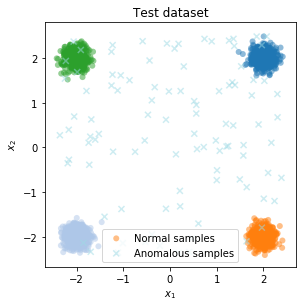

In [17]:
plt.clf()
fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/15.0),
           edgecolor='none', alpha=0.5, label="Normal samples")

ax.scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/15),
       edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')

ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Test dataset")
ax.legend()
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()

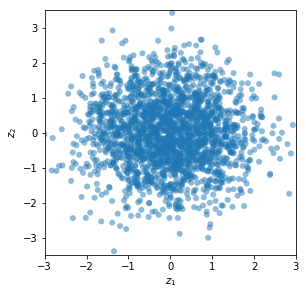

In [18]:
# create Z dataset

datasetZ_test = sample_GMM(X_np_data_test.shape[0], means_z, variances_z, priors_z, sources=('features', ))
save_path = result_dir + 'Z_gmm_data_test.png'
# plot_GMM(dataset, save_path)

Z_np_data_test = datasetZ_test.data['samples']
Z_targets_test = datasetZ_test.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_np_data_test[:, 0], Z_np_data_test[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(save_path, transparent=True, bbox_inches='tight')
plt.show()

In [19]:
### Testing

In [20]:
x = torch.Tensor(X_np_data_test) 
z = torch.Tensor(Z_np_data_test)

imx = gen(z).data.cpu().numpy()
imz = inf(x).data.cpu().numpy()
rmz = inf( gen(z) ).data.cpu().numpy()
rmx = gen( inf(x) ).data.cpu().numpy()


mahalanobis_dis_z = torch.norm(inf(x), p=2, dim=1)

score_dz = mahalanobis_dis_z

score = score_dz #+ score_dxx
score = np.linalg.norm(imz, ord=2, axis=1, keepdims = False)
print(score)

def zmar(imz):
    return np.linalg.norm(imz, ord=2, axis=1, keepdims=False)

[1.3684056 1.4004058 1.7402287 ... 2.062337  0.7874204 1.1283427]


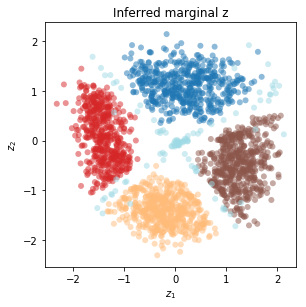

In [21]:
## inferred marginal z
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ll = X_targets_test
ax.scatter(imz[:, 0], imz[:, 1], c=cm.tab20(ll.astype(float)/input_dim/3.0),
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title("Inferred marginal z")
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

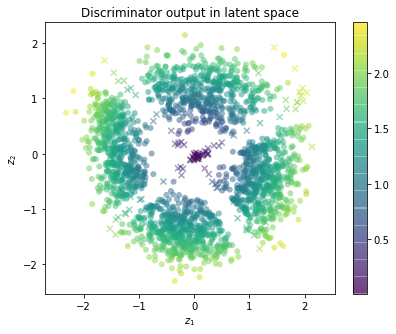

In [22]:
import matplotlib as mpl

## discriminator z choice on latent - v3
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 5))

colors = score#zmar(score)
norm = mpl.colors.Normalize(vmin=min(colors), vmax=max(colors))

im = ax.scatter(imz[idx_inliers, 0], imz[idx_inliers, 1], c=colors[idx_inliers],
        edgecolor='none', alpha=0.5, label="Normal samples", marker='o', norm=norm)

im = ax.scatter(imz[idx_outliers, 0], imz[idx_outliers, 1], c=colors[idx_outliers],
        edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x', norm=norm)

#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
fig_mz.colorbar(im)
ax.axis('on')
plt.axis('equal')
ax.set_title("Discriminator output in latent space")
plt.savefig(result_dir + 'inferred_{}_mz_disc.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

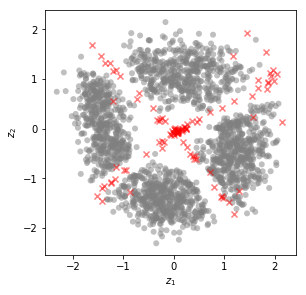

In [23]:
## discriminator z choice on latent - v2
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(imz[idx_inliers][:, 0], imz[idx_inliers][:, 1], c='grey',
        edgecolor='none', alpha=0.5)
ax.scatter(imz[idx_outliers][:, 0], imz[idx_outliers][:, 1], c='r',
        edgecolor='none', alpha=0.5, marker='x')
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

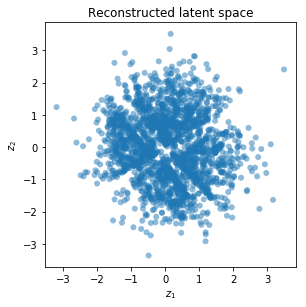

In [24]:


##  reconstructed z
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(rmz[:, 0], rmz[:, 1],
           edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title('Reconstructed latent space')
plt.savefig(result_dir + 'reconstruct_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()



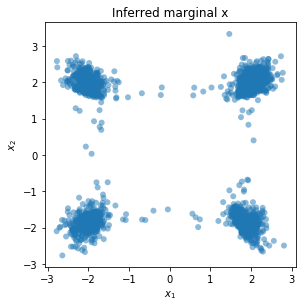

In [25]:
## inferred marginal x
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(imx[:, 0], imx[:, 1],
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Inferred marginal x")
plt.savefig(result_dir + 'inferred_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

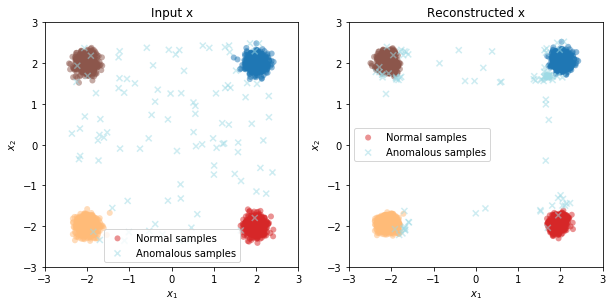

In [26]:
##  reconstructed x
fig_mx, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))
ax[0].scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[0].scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[0].set_xlabel('$x_1$'); ax[0].set_ylabel('$x_2$')
ax[0].axis('on')
ax[0].set_xlim(-3, 3); ax[0].set_ylim(-3, 3)
ax[0].legend()
ax[0].set_title("Input x")

ax[1].scatter(rmx[idx_inliers, 0], rmx[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[1].scatter(rmx[idx_outliers, 0], rmx[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[1].set_xlim(-3, 3); ax[1].set_ylim(-3, 3)
ax[1].set_xlabel('$x_1$'); ax[1].set_ylabel('$x_2$')
ax[1].axis('on')
ax[1].legend()
ax[1].set_title("Reconstructed x")
plt.savefig(result_dir + 'reconstruct_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

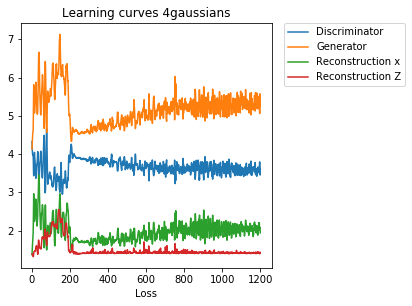

In [27]:

## learning curves
fig_curve, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.plot(FD, label="Discriminator")
ax.plot(np.array(FG)[:,0], label="Generator")
ax.plot(np.array(FG)[:,1], label="Reconstruction x")
ax.plot(np.array(FG)[:,2], label="Reconstruction Z")
plt.xlabel('Iteration')
plt.xlabel('Loss')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axis('on')
ax.set_title("Learning curves {}".format(DATASET))
plt.savefig(result_dir + 'learning_curves_{}.png'.format(DATASET), bbox_inches='tight')
plt.show()
